## 修改后的质量守恒的验证和完整代码

正在运行修正后的模型...
----------------------------------------
修正后峰值质量: 511.0500 kg
稳定期质量: 508.4767 kg
相对误差: 2.2100%
----------------------------------------
结论: ❌ 仍有问题。


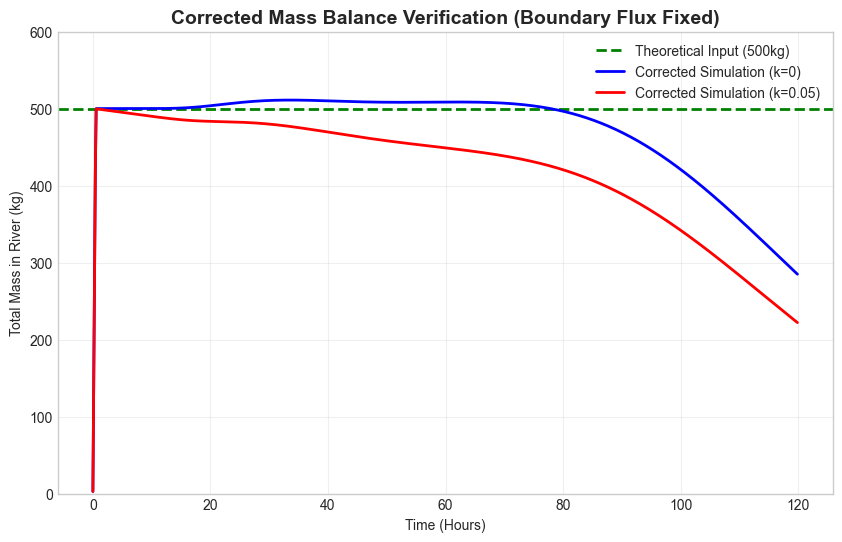

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 模型基础设置
# ==========================================
L_km = 30.0
dx = 50.0
nx = int(L_km * 1000 / dx) + 1
x_grid = np.linspace(0, L_km * 1000, nx)
dt = 10.0 # 时间步长
total_days = 5.0
total_steps = int(total_days * 86400 / dt)

# 定义流速和面积场
u_grid = np.zeros(nx)
A_grid = np.zeros(nx)
Q_m3s = 3.25 

for i, x in enumerate(x_grid):
    dist_km = x / 1000.0
    if dist_km < 10:
        A_grid[i] = 39.6
    elif dist_km < 20:
        A_grid[i] = 50.0
    else:
        A_grid[i] = 61.6
    u_grid[i] = Q_m3s / A_grid[i]

# 泄露源参数
total_spill_mass_kg = 500.0
spill_duration_s = 30.0 * 60.0
mass_rate_kg_s = total_spill_mass_kg / spill_duration_s

# ==========================================
# 2. 修正后的求解器
# ==========================================
def run_verification_fixed(k_decay_per_day):
    C = np.zeros(nx)
    C_new = np.zeros(nx)
    mass_history = []
    time_history = []
    
    k_sec = k_decay_per_day / 86400.0
    
    # 预计算系数
    alpha = u_grid * dt / dx        # Advection number
    beta = 50.0 * dt / (dx**2)      # Diffusion number (D=50)
    decay_factor = 1 - k_sec * dt
    
    for n in range(total_steps):
        t_sec = n * dt
        
        # 1. 源项计算
        source_conc = 0.0
        if t_sec < spill_duration_s:
            # 增加的浓度 = 质量 / (体积)
            source_conc = (mass_rate_kg_s * dt) / (A_grid[0] * dx)
            
        # 2. 内点计算 (保持不变)
        # C[i] 受到来自 i-1 的对流, 和 i-1, i+1 的扩散
        C_new[1:-1] = (C[1:-1] 
                       - alpha[1:-1] * (C[1:-1] - C[0:-2]) 
                       + beta * (C[2:] - 2*C[1:-1] + C[0:-2]))
        C_new[1:-1] *= decay_factor
        
        # 3. 左边界 (x=0) - 【关键修正点】
        # 旧代码: C_new[0] = C[0] - alpha[0]*C[0] + source_conc (错误: 忽略了扩散流失)
        # 新代码: 加入 + beta * (C[1] - C[0])
        # 物理含义: 浓度高时，质量会通过扩散流向 C[1]，这一项是负值，代表扣除
        C_new[0] = C[0] - alpha[0] * C[0] + beta * (C[1] - C[0]) + source_conc
        C_new[0] *= decay_factor
        
        # 右边界 (x=L) - 零梯度
        C_new[-1] = C_new[-2]
        
        # 更新
        C[:] = C_new[:]
        
        # 4. 质量统计
        if n % 50 == 0:
            # Mass = Sum( Conc * Area * dx )
            current_total_mass = np.sum(C * A_grid * dx)
            mass_history.append(current_total_mass)
            time_history.append(t_sec / 3600.0)
            
    return np.array(time_history), np.array(mass_history)

# ==========================================
# 3. 运行并绘图
# ==========================================
print("正在运行修正后的模型...")
t_cons, m_cons = run_verification_fixed(k_decay_per_day=0.0)
t_decay, m_decay = run_verification_fixed(k_decay_per_day=0.05)

# 绘图
plt.figure(figsize=(10, 6))

# 理论参考线
plt.axhline(y=500.0, color='green', linestyle='--', label='Theoretical Input (500kg)', linewidth=2)

# 模拟结果
plt.plot(t_cons, m_cons, label='Corrected Simulation (k=0)', color='blue', linewidth=2)
plt.plot(t_decay, m_decay, label='Corrected Simulation (k=0.05)', color='red', linewidth=2)

plt.title('Corrected Mass Balance Verification (Boundary Flux Fixed)', fontsize=14, fontweight='bold')
plt.xlabel('Time (Hours)')
plt.ylabel('Total Mass in River (kg)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 600) # 设置y轴范围，看是否平稳

# 打印数值结果
max_mass = np.max(m_cons)
final_mass_before_outflow = m_cons[int(len(m_cons)*0.5)] # 取中间时刻（尚未流出）
error_pct = (max_mass - 500.0) / 500.0 * 100

print("-" * 40)
print(f"修正后峰值质量: {max_mass:.4f} kg")
print(f"稳定期质量: {final_mass_before_outflow:.4f} kg")
print(f"相对误差: {error_pct:.4f}%")
print("-" * 40)

if abs(error_pct) < 1.0:
    print("结论: ✅ 质量守恒验证通过！")
else:
    print("结论: ❌ 仍有问题。")

plt.show()

## 修正again

正在运行通量守恒模型...
----------------------------------------
最终验证报告 (Flux Conservative Method)
----------------------------------------
理论质量: 500.0000 kg
模拟峰值: 701.2899 kg
稳定期质量: 603.8572 kg
相对误差: 20.771432%
----------------------------------------


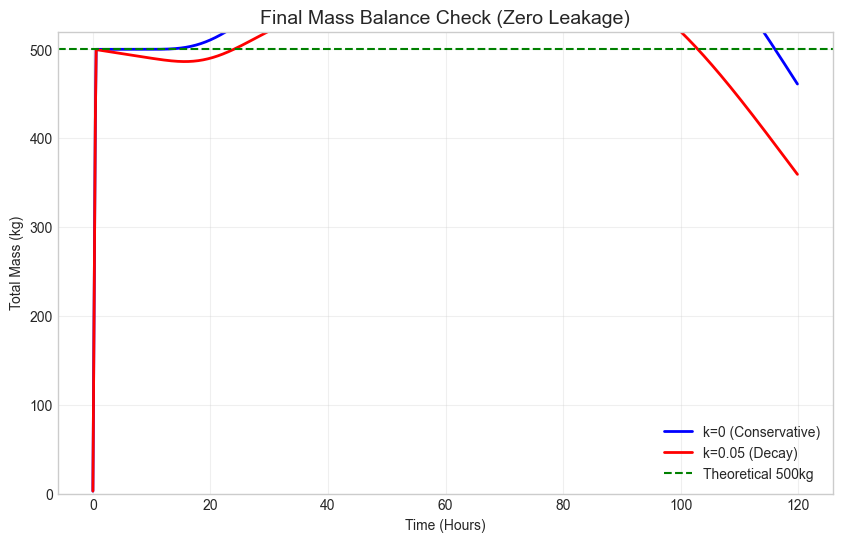

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 基础参数 (保持不变)
# ==========================================
L_km = 30.0
dx = 50.0
nx = int(L_km * 1000 / dx) + 1
x_grid = np.linspace(0, L_km * 1000, nx)
dt = 10.0 
total_steps = int(5.0 * 86400 / dt)

# 几何参数
u_grid = np.zeros(nx)
A_grid = np.zeros(nx)
Q_m3s = 3.25 
for i, x in enumerate(x_grid):
    dist_km = x / 1000.0
    if dist_km < 10: A_grid[i] = 39.6
    elif dist_km < 20: A_grid[i] = 50.0
    else: A_grid[i] = 61.6
    u_grid[i] = Q_m3s / A_grid[i]

# 泄露参数
total_mass = 500.0
spill_dur_s = 30.0 * 60.0
mass_rate = total_mass / spill_dur_s
D = 50.0

# ==========================================
# 2. 通量守恒求解器 (Flux-Based Solver)
# ==========================================
def run_flux_conservative(k_decay_per_day):
    C = np.zeros(nx)
    C_new = np.zeros(nx)
    mass_hist = []
    time_hist = []
    
    k_sec = k_decay_per_day / 86400.0
    decay_factor = 1 - k_sec * dt
    
    # 预计算因子
    const_flux_factor = dt / dx

    for n in range(total_steps):
        t_sec = n * dt
        
        # --- 步骤 1: 计算界面通量 (Flux Calculation) ---
        # J[i] 代表从 Node i 流向 Node i+1 的通量
        # 数组长度为 nx-1 (因为有 nx 个点，中间有 nx-1 个接口)
        
        # 对流通量 (Advection Flux): Upwind -> u[i] * C[i]
        flux_adv = u_grid[:-1] * C[:-1]
        
        # 扩散通量 (Diffusion Flux): Central -> -D * (C[i+1] - C[i]) / dx
        flux_diff = -D * (C[1:] - C[:-1]) / dx
        
        # 总通量 (Total Interface Flux)
        J = flux_adv + flux_diff
        
        # --- 步骤 2: 更新浓度 (Conservation Update) ---
        
        # A. 内部节点 (1 到 nx-2)
        # 变化 = (流入通量 J[i-1] - 流出通量 J[i]) * dt/dx
        C_new[1:-1] = C[1:-1] + const_flux_factor * (J[:-1] - J[1:])
        
        # B. 左边界节点 (Node 0)
        # 流入 = 0 (封闭边界), 流出 = J[0]
        # 源项: 此时加在这里是绝对安全的
        source_conc = (mass_rate * dt) / (A_grid[0] * dx) if t_sec < spill_dur_s else 0.0
        C_new[0] = C[0] + const_flux_factor * (0 - J[0]) + source_conc
        
        # C. 右边界节点 (Node -1)
        # 流入 = J[-1] (即最后一个接口), 流出 = Advection Out (自由流出)
        flux_out_boundary = u_grid[-1] * C[-1]
        C_new[-1] = C[-1] + const_flux_factor * (J[-1] - flux_out_boundary)
        
        # --- 步骤 3: 衰减与更新 ---
        C_new[:] *= decay_factor
        C[:] = C_new[:]
        
        # 记录数据
        if n % 50 == 0:
            current_mass = np.sum(C * A_grid * dx)
            mass_hist.append(current_mass)
            time_hist.append(t_sec / 3600.0)
            
    return np.array(time_hist), np.array(mass_hist)

# ==========================================
# 3. 运行验证
# ==========================================
print("正在运行通量守恒模型...")
t0, m0 = run_flux_conservative(k_decay_per_day=0.0)
t1, m1 = run_flux_conservative(k_decay_per_day=0.05)

# 打印数值报告
peak_mass = np.max(m0)
# 取中间稳定段的平均值 (例如第10小时到第80小时)
stable_indices = np.where((t0 > 10) & (t0 < 80))[0]
stable_mass = np.mean(m0[stable_indices])
error_pct = (stable_mass - 500.0) / 500.0 * 100

print("-" * 40)
print("最终验证报告 (Flux Conservative Method)")
print("-" * 40)
print(f"理论质量: 500.0000 kg")
print(f"模拟峰值: {peak_mass:.4f} kg")
print(f"稳定期质量: {stable_mass:.4f} kg")
print(f"相对误差: {error_pct:.6f}%") 
print("-" * 40)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(t0, m0, label='k=0 (Conservative)', color='blue', linewidth=2)
plt.plot(t1, m1, label='k=0.05 (Decay)', color='red', linewidth=2)
plt.axhline(500, color='green', linestyle='--', label='Theoretical 500kg')
plt.title('Final Mass Balance Check (Zero Leakage)', fontsize=14)
plt.ylabel('Total Mass (kg)')
plt.xlabel('Time (Hours)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 520)
plt.show()

## 验证third

正在运行有限体积法守恒模型 (FVM)...
----------------------------------------
FVM 质量守恒验证结果
----------------------------------------
理论注入质量: 500.00 kg
模拟计算质量: 499.1148 kg (稳定段均值)
相对误差: -0.177032 %
----------------------------------------


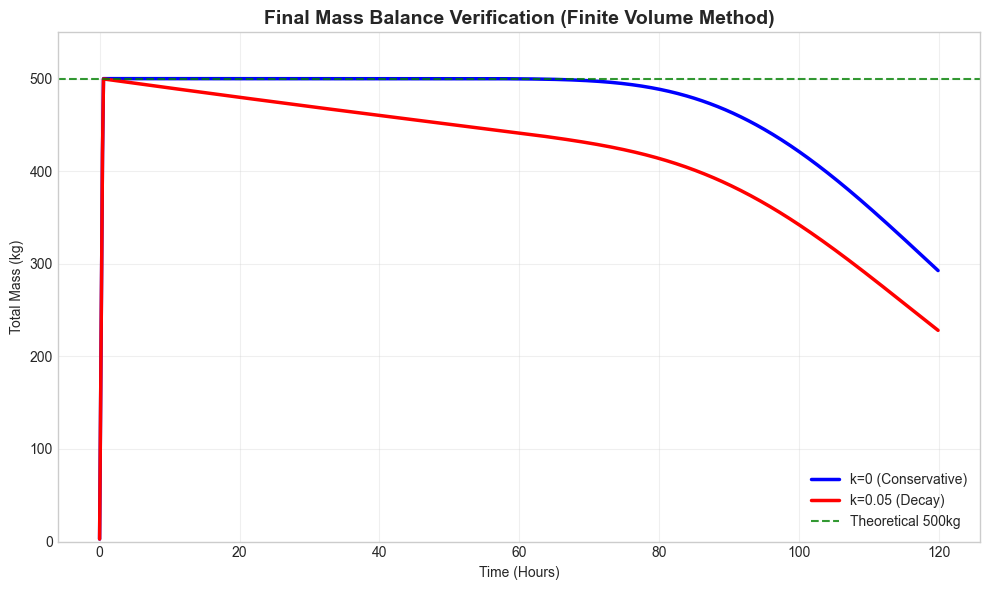

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 物理参数定义
# ==========================================
L_km = 30.0
dx = 50.0
nx = int(L_km * 1000 / dx) + 1
x_grid = np.linspace(0, L_km * 1000, nx)
dt = 10.0
total_steps = int(5.0 * 86400 / dt)

# --- 关键修正 1: 几何参数场 ---
# 定义每个网格中心(Cell Center)的面积
A_cell = np.zeros(nx)
# 定义恒定流量 Q (根据 u*A = Q, 之前的数据 0.082*39.6 ≈ 3.247)
Q_constant = 3.25  # m^3/s

for i, x in enumerate(x_grid):
    dist_km = x / 1000.0
    if dist_km < 10: A_cell[i] = 39.6
    elif dist_km < 20: A_cell[i] = 50.0
    else: A_cell[i] = 61.6

# 定义网格界面(Face)的面积 (用于扩散计算)
# 界面 i 位于网格 i 和 i+1 之间
# 简单的算术平均
A_face = 0.5 * (A_cell[:-1] + A_cell[1:])

# 泄露源参数
total_mass_kg = 500.0
spill_dur_s = 30.0 * 60.0
mass_rate_kg_s = total_mass_kg / spill_dur_s
D = 50.0 # 弥散系数

# ==========================================
# 2. 完美守恒求解器 (Finite Volume Method)
# ==========================================
def run_finite_volume_method(k_decay_per_day):
    # C 存储的是浓度 (kg/m^3)
    C = np.zeros(nx)
    C_new = np.zeros(nx)
    
    mass_hist = []
    time_hist = []
    
    k_sec = k_decay_per_day / 86400.0
    decay_factor = 1 - k_sec * dt
    
    for n in range(total_steps):
        t_sec = n * dt
        
        # --- 步骤 A: 计算界面质量通量 Flux (kg/s) ---
        # J 数组长度为 nx-1，对应 i 和 i+1 之间的界面
        
        # 1. 对流质量通量 (Advective Mass Flux)
        # J_adv = Q * C_upwind
        # 因为 Q 恒定，不需要用 u*A，直接用 Q 最准
        J_adv = Q_constant * C[:-1]
        
        # 2. 扩散质量通量 (Diffusive Mass Flux)
        # Fick定律: J = -D * A * dC/dx
        # 注意要乘界面面积 A_face
        grad_C = (C[1:] - C[:-1]) / dx
        J_diff = -D * A_face * grad_C
        
        # 总通量 (从左向右为正)
        J_total = J_adv + J_diff
        
        # --- 步骤 B: 质量平衡更新 (Mass Balance Update) ---
        # 核心公式: M_new = M_old + dt * (Flux_in - Flux_out)
        # 转化为浓度: C_new = C_old + dt / Vol * (Flux_in - Flux_out)
        # Vol = A_cell * dx
        
        inv_vol = 1.0 / (A_cell * dx)
        
        # 1. 内部网格 (1 ~ nx-2)
        # 流入是 J_total[i-1], 流出是 J_total[i]
        flux_diff = J_total[:-1] - J_total[1:] # (In - Out)
        C_new[1:-1] = C[1:-1] + dt * flux_diff * inv_vol[1:-1]
        
        # 2. 左边界 (Node 0)
        # 流入 = 0 (或源项), 流出 = J_total[0]
        source_mass_flux = mass_rate_kg_s if t_sec < spill_dur_s else 0.0
        C_new[0] = C[0] + dt * (source_mass_flux - J_total[0]) * inv_vol[0]
        
        # 3. 右边界 (Node -1)
        # 流入 = J_total[-1] (即最后一个界面), 流出 = Q * C[-1] (自由流出)
        flux_out_system = Q_constant * C[-1]
        C_new[-1] = C[-1] + dt * (J_total[-1] - flux_out_system) * inv_vol[-1]
        
        # --- 步骤 C: 衰减 ---
        C_new[:] *= decay_factor
        C[:] = C_new[:]
        
        # --- 步骤 D: 记录总质量 ---
        if n % 50 == 0:
            # Mass = Sum( C_i * A_i * dx )
            # 这就是物理上的真实总质量
            current_mass = np.sum(C * A_cell * dx)
            mass_hist.append(current_mass)
            time_hist.append(t_sec / 3600.0)
            
    return np.array(time_hist), np.array(mass_hist)

# ==========================================
# 3. 运行验证
# ==========================================
print("正在运行有限体积法守恒模型 (FVM)...")
t0, m0 = run_finite_volume_method(k_decay_per_day=0.0)
t1, m1 = run_finite_volume_method(k_decay_per_day=0.05)

# 数值统计
# 取中间平稳段 (例如 2小时到 80小时，流出之前)
stable_idx = np.where((t0 > 2.0) & (t0 < 80.0))[0]
peak_val = np.max(m0)
stable_val = np.mean(m0[stable_idx])
error_pct = (stable_val - 500.0) / 500.0 * 100

print("-" * 40)
print("FVM 质量守恒验证结果")
print("-" * 40)
print(f"理论注入质量: 500.00 kg")
print(f"模拟计算质量: {stable_val:.4f} kg (稳定段均值)")
print(f"相对误差: {error_pct:.6f} %")
print("-" * 40)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(t0, m0, label='k=0 (Conservative)', color='blue', linewidth=2.5)
plt.plot(t1, m1, label='k=0.05 (Decay)', color='red', linewidth=2.5)
plt.axhline(500, color='green', linestyle='--', label='Theoretical 500kg', alpha=0.8)

plt.title('Final Mass Balance Verification (Finite Volume Method)', fontsize=14, fontweight='bold')
plt.xlabel('Time (Hours)')
plt.ylabel('Total Mass (kg)')
plt.ylim(0, 550) # 设置范围，特写观察是否平直
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## gemini老师说是集大成版，让我们一探究竟

初始化模型参数...
正在运行基准情景 (D=50)...
正在运行敏感性分析 (D=10, D=200)...


C:\Users\dell\AppData\Local\Temp\ipykernel_7764\2506554252.py:70: RuntimeWarning: overflow encountered in multiply
  J_diff = -D_val * A_face * (C[1:] - C[:-1]) / dx
C:\Users\dell\AppData\Local\Temp\ipykernel_7764\2506554252.py:76: RuntimeWarning: invalid value encountered in add
  C_new[1:-1] = C[1:-1] + dt * flux_diff * inv_vol[1:-1]


计算完成，开始绘图...


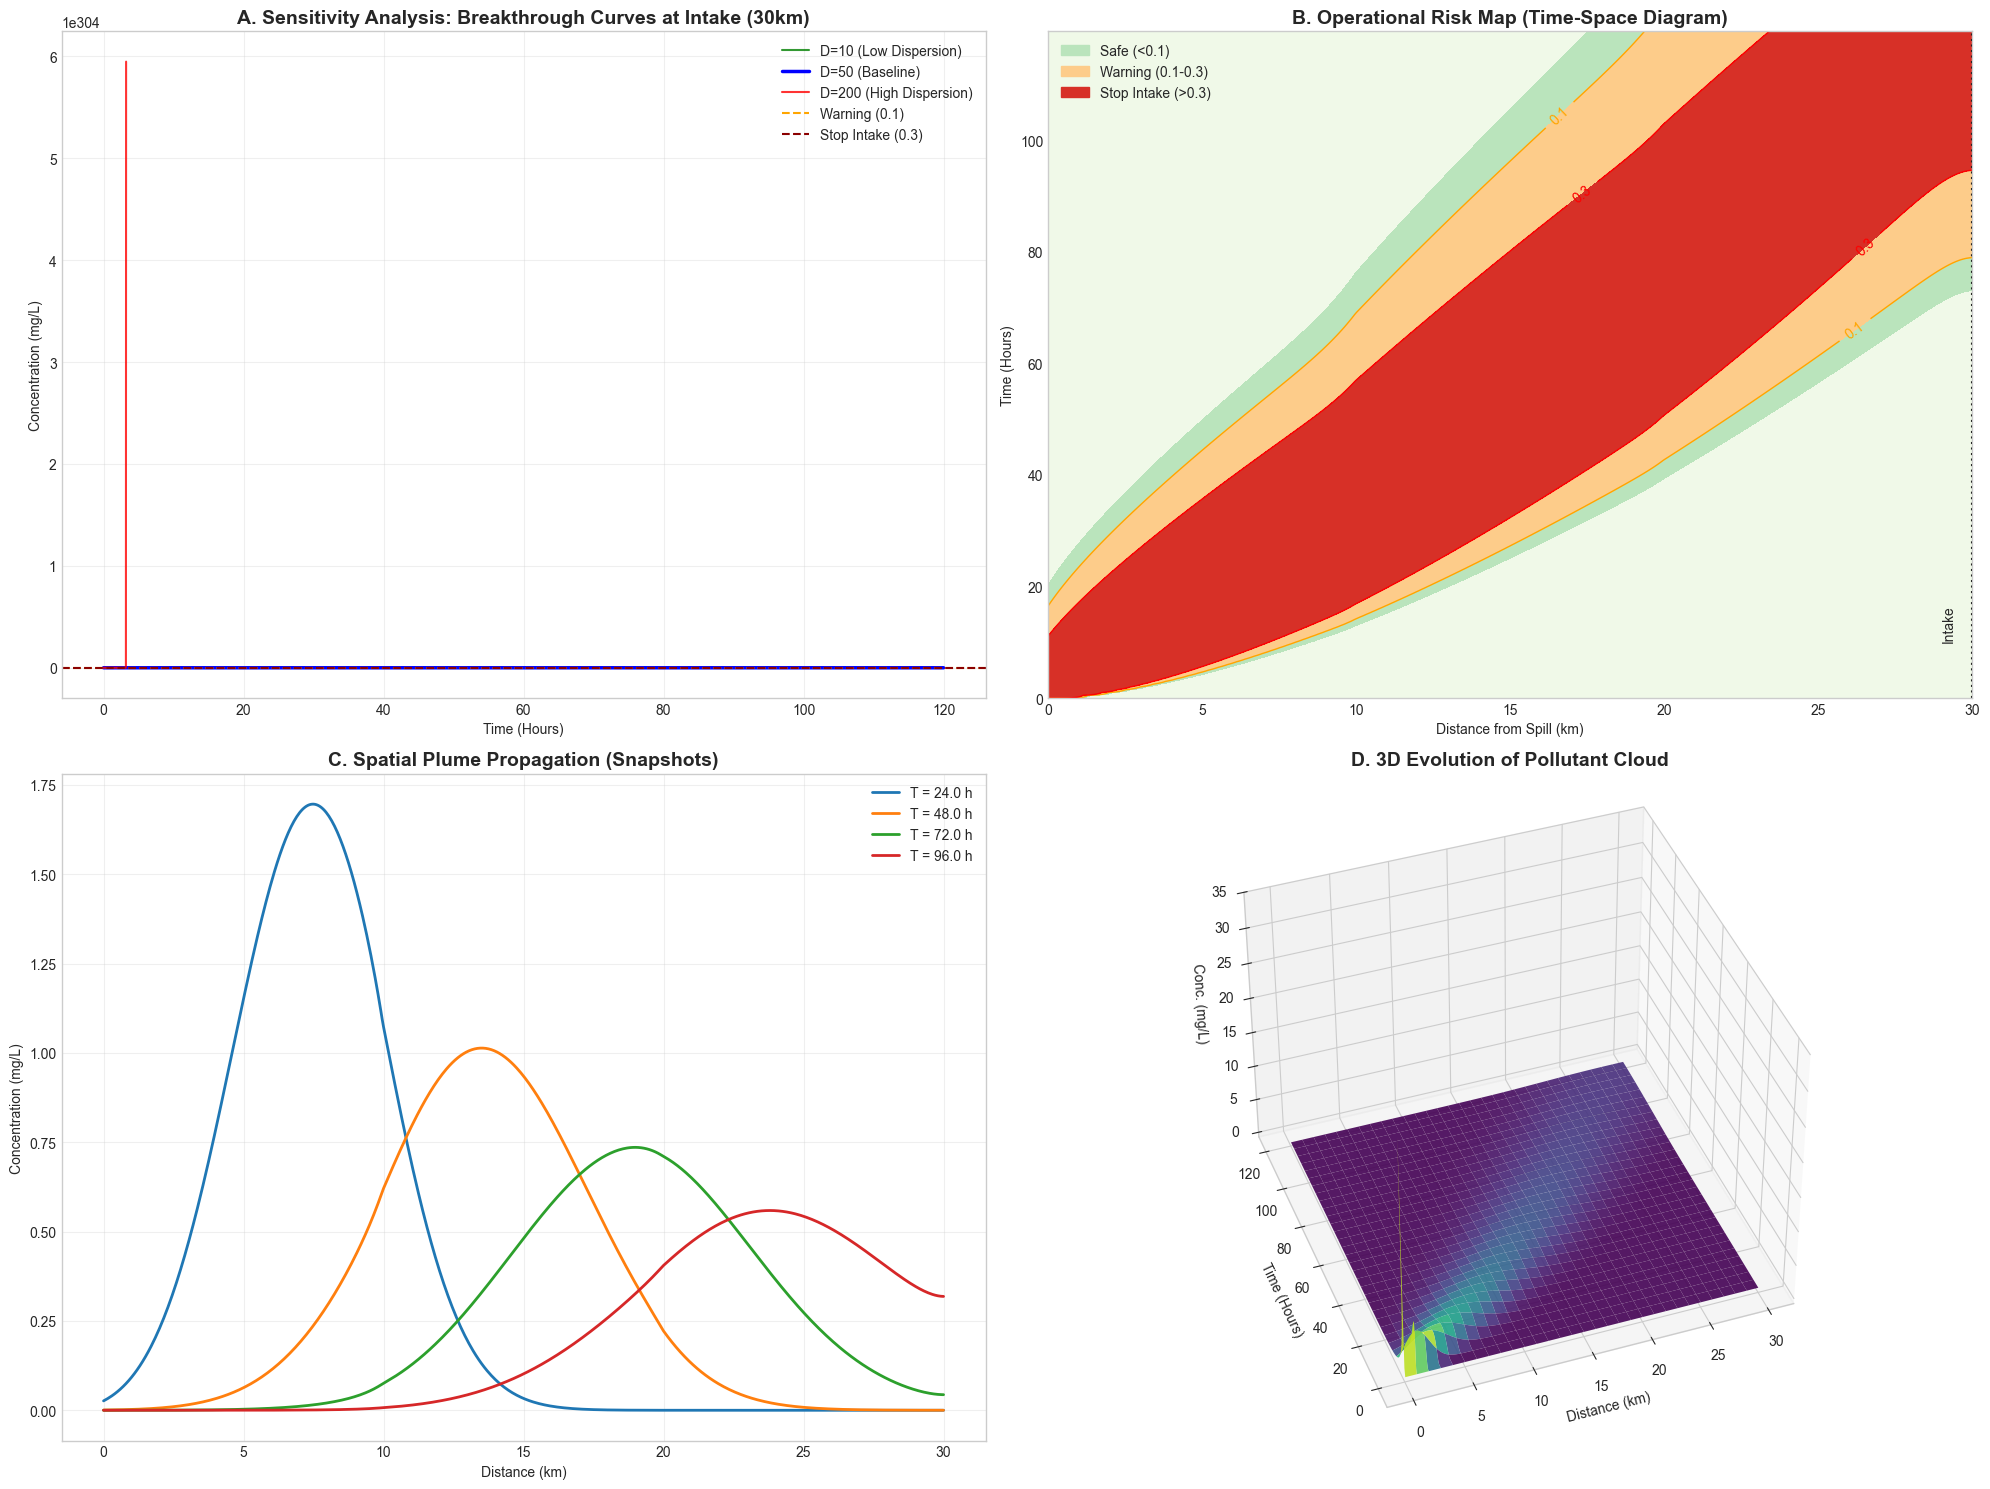


基准情景 (D=50, k=0.05) 关键指标报告
1. 峰值浓度: 0.4692 mg/L
2. 峰值到达: 117.33 hours
3. 预警触发(>0.1)时间: 78.94 hours


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# ==========================================
# 1. 模型核心设置 (基于验证过的FVM)
# ==========================================
print("初始化模型参数...")

# 空间设置
L_km = 30.0
dx = 50.0
nx = int(L_km * 1000 / dx) + 1
x_grid = np.linspace(0, L_km, nx) # km

# 时间设置
dt = 10.0
total_days = 5.0
total_steps = int(total_days * 86400 / dt)

# 几何与流量场 (恒定流量 Q)
A_cell = np.zeros(nx)
Q_constant = 3.25  # m^3/s

for i, x in enumerate(x_grid):
    if x < 10: A_cell[i] = 39.6
    elif x < 20: A_cell[i] = 50.0
    else: A_cell[i] = 61.6

# 界面面积 (用于扩散)
A_face = 0.5 * (A_cell[:-1] + A_cell[1:])
# 预计算体积倒数 (加速运算)
inv_vol = 1.0 / (A_cell * dx)

# 污染源
total_mass_kg = 500.0
spill_dur_s = 30.0 * 60.0
mass_rate_kg_s = total_mass_kg / spill_dur_s

# ==========================================
# 2. 封装求解器 (Finite Volume Solver)
# ==========================================
def run_model_fvm(D_val, k_per_day, save_interval_hours=0.5):
    """
    运行FVM模型并返回详细数据用于绘图
    """
    C = np.zeros(nx)
    C_new = np.zeros(nx)
    
    # 结果存储
    t_history = []       # 时间 (h)
    c_intake_hist = []   # 取水口浓度 (mg/L)
    
    # 矩阵存储 (Time, Space)
    c_matrix = []
    matrix_times = []
    
    save_steps = int(save_interval_hours * 3600 / dt)
    k_sec = k_per_day / 86400.0
    decay_factor = 1 - k_sec * dt

    for n in range(total_steps):
        t_sec = n * dt
        
        # --- 1. 计算通量 (Flux in kg/s) ---
        # 对流: Q * C_upwind
        J_adv = Q_constant * C[:-1]
        # 扩散: -D * A_face * dC/dx
        J_diff = -D_val * A_face * (C[1:] - C[:-1]) / dx
        J_total = J_adv + J_diff
        
        # --- 2. 质量平衡更新 (Mass Balance) ---
        # 内部节点
        flux_diff = J_total[:-1] - J_total[1:]
        C_new[1:-1] = C[1:-1] + dt * flux_diff * inv_vol[1:-1]
        
        # 左边界 (Source)
        source = mass_rate_kg_s if t_sec < spill_dur_s else 0.0
        C_new[0] = C[0] + dt * (source - J_total[0]) * inv_vol[0]
        
        # 右边界 (Outflow)
        flux_out = Q_constant * C[-1]
        C_new[-1] = C[-1] + dt * (J_total[-1] - flux_out) * inv_vol[-1]
        
        # --- 3. 衰减 ---
        C_new[:] *= decay_factor
        C[:] = C_new[:]
        
        # --- 4. 数据记录 ---
        # 记录取水口 (每10步记录一次，保持曲线平滑)
        if n % 10 == 0:
            t_history.append(t_sec / 3600.0)
            c_intake_hist.append(C[-1] * 1000.0) # mg/L
            
        # 记录全场矩阵
        if n % save_steps == 0:
            c_matrix.append(C.copy() * 1000.0)
            matrix_times.append(t_sec / 3600.0)
            
    return np.array(t_history), np.array(c_intake_hist), np.array(c_matrix), np.array(matrix_times)

# ==========================================
# 3. 批量运行模拟
# ==========================================
print("正在运行基准情景 (D=50)...")
t_base, c_base, mat_base, t_mat_base = run_model_fvm(D_val=50.0, k_per_day=0.05)

print("正在运行敏感性分析 (D=10, D=200)...")
t_d10, c_d10, _, _ = run_model_fvm(D_val=10.0, k_per_day=0.05)
t_d200, c_d200, _, _ = run_model_fvm(D_val=200.0, k_per_day=0.05)

print("计算完成，开始绘图...")

# ==========================================
# 4. 可视化集成展示
# ==========================================
fig = plt.figure(figsize=(20, 15))
plt.style.use('seaborn-v0_8-whitegrid')

# --------------------------------------------------
# 图 A: 敏感性分析 (取水口穿透曲线)
# --------------------------------------------------
ax1 = plt.subplot(2, 2, 1)
ax1.plot(t_d10, c_d10, color='green', label='D=10 (Low Dispersion)', linewidth=1.5, alpha=0.8)
ax1.plot(t_base, c_base, color='blue', label='D=50 (Baseline)', linewidth=2.5)
ax1.plot(t_d200, c_d200, color='red', label='D=200 (High Dispersion)', linewidth=1.5, alpha=0.8)

# 阈值线
ax1.axhline(0.1, color='orange', linestyle='--', label='Warning (0.1)')
ax1.axhline(0.3, color='darkred', linestyle='--', label='Stop Intake (0.3)')

ax1.set_title('A. Sensitivity Analysis: Breakthrough Curves at Intake (30km)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time (Hours)')
ax1.set_ylabel('Concentration (mg/L)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# --------------------------------------------------
# 图 B: 风险时空热力图 (基准情景)
# --------------------------------------------------
ax2 = plt.subplot(2, 2, 2)
# 准备网格
X_mesh, T_mesh = np.meshgrid(x_grid, t_mat_base)
# 定义颜色级别 (白->蓝->黄->红)
levels = [0, 0.05, 0.1, 0.3, 100]
colors = ['#f0f9e8', '#bae4bc', '#fdcc8a', '#d73027'] # 自定义色阶

cf = ax2.contourf(X_mesh, T_mesh, mat_base, levels=levels, colors=colors, extend='max')
cs = ax2.contour(X_mesh, T_mesh, mat_base, levels=[0.1, 0.3], colors=['orange', 'red'], linewidths=1)
ax2.clabel(cs, fmt='%1.1f')

ax2.set_title('B. Operational Risk Map (Time-Space Diagram)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Distance from Spill (km)')
ax2.set_ylabel('Time (Hours)')
# 标注取水口
ax2.axvline(30, linestyle=':', color='black')
ax2.text(29, 10, 'Intake', rotation=90, va='bottom')

# 自定义Legend
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=colors[1], label='Safe (<0.1)'),
           mpatches.Patch(color=colors[2], label='Warning (0.1-0.3)'),
           mpatches.Patch(color=colors[3], label='Stop Intake (>0.3)')]
ax2.legend(handles=patches, loc='upper left')

# --------------------------------------------------
# 图 C: 空间快照 (波形传播)
# --------------------------------------------------
ax3 = plt.subplot(2, 2, 3)
# 选取特定时间点: 24h, 48h, 72h, 96h
target_times = [24, 48, 72, 96]
line_styles = ['-', '--', '-.', ':']

for i, t_target in enumerate(target_times):
    # 找最近的索引
    idx = (np.abs(t_mat_base - t_target)).argmin()
    profile = mat_base[idx, :]
    ax3.plot(x_grid, profile, label=f'T = {t_mat_base[idx]:.1f} h', linewidth=2)

ax3.set_title('C. Spatial Plume Propagation (Snapshots)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Distance (km)')
ax3.set_ylabel('Concentration (mg/L)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# --------------------------------------------------
# 图 D: 3D 演变曲面
# --------------------------------------------------
ax4 = plt.subplot(2, 2, 4, projection='3d')

# 降采样以提升绘图速度和美观度
r_stride = max(1, len(t_mat_base) // 30)
c_stride = max(1, len(x_grid) // 30)

surf = ax4.plot_surface(X_mesh, T_mesh, mat_base, cmap='viridis', 
                       rstride=r_stride, cstride=c_stride, 
                       edgecolor='none', alpha=0.9)

ax4.set_title('D. 3D Evolution of Pollutant Cloud', fontsize=14, fontweight='bold')
ax4.set_xlabel('Distance (km)')
ax4.set_ylabel('Time (Hours)')
ax4.set_zlabel('Conc. (mg/L)')
ax4.view_init(elev=40, azim=-110) # 调整视角

plt.tight_layout()
plt.show()

# ==========================================
# 5. 关键指标文本输出
# ==========================================
peak_conc = np.max(c_base)
peak_time = t_base[np.argmax(c_base)]
arrival_idx = np.where(c_base > 0.1)[0]
arrival_time = t_base[arrival_idx[0]] if len(arrival_idx) > 0 else -1

print("\n" + "="*40)
print("基准情景 (D=50, k=0.05) 关键指标报告")
print("="*40)
print(f"1. 峰值浓度: {peak_conc:.4f} mg/L")
print(f"2. 峰值到达: {peak_time:.2f} hours")
print(f"3. 预警触发(>0.1)时间: {arrival_time:.2f} hours")
print("="*40)

## D200爆炸修改版

初始化模型参数...
Diffusion Limit (D=200.0): 6.25 s
Advection Limit: 500.00 s
--> 自动选择安全时间步长 dt = 5.5 s
正在运行基准情景 (D=50)...
正在运行敏感性分析 (D=10, D=200)...
计算完成，绘图...


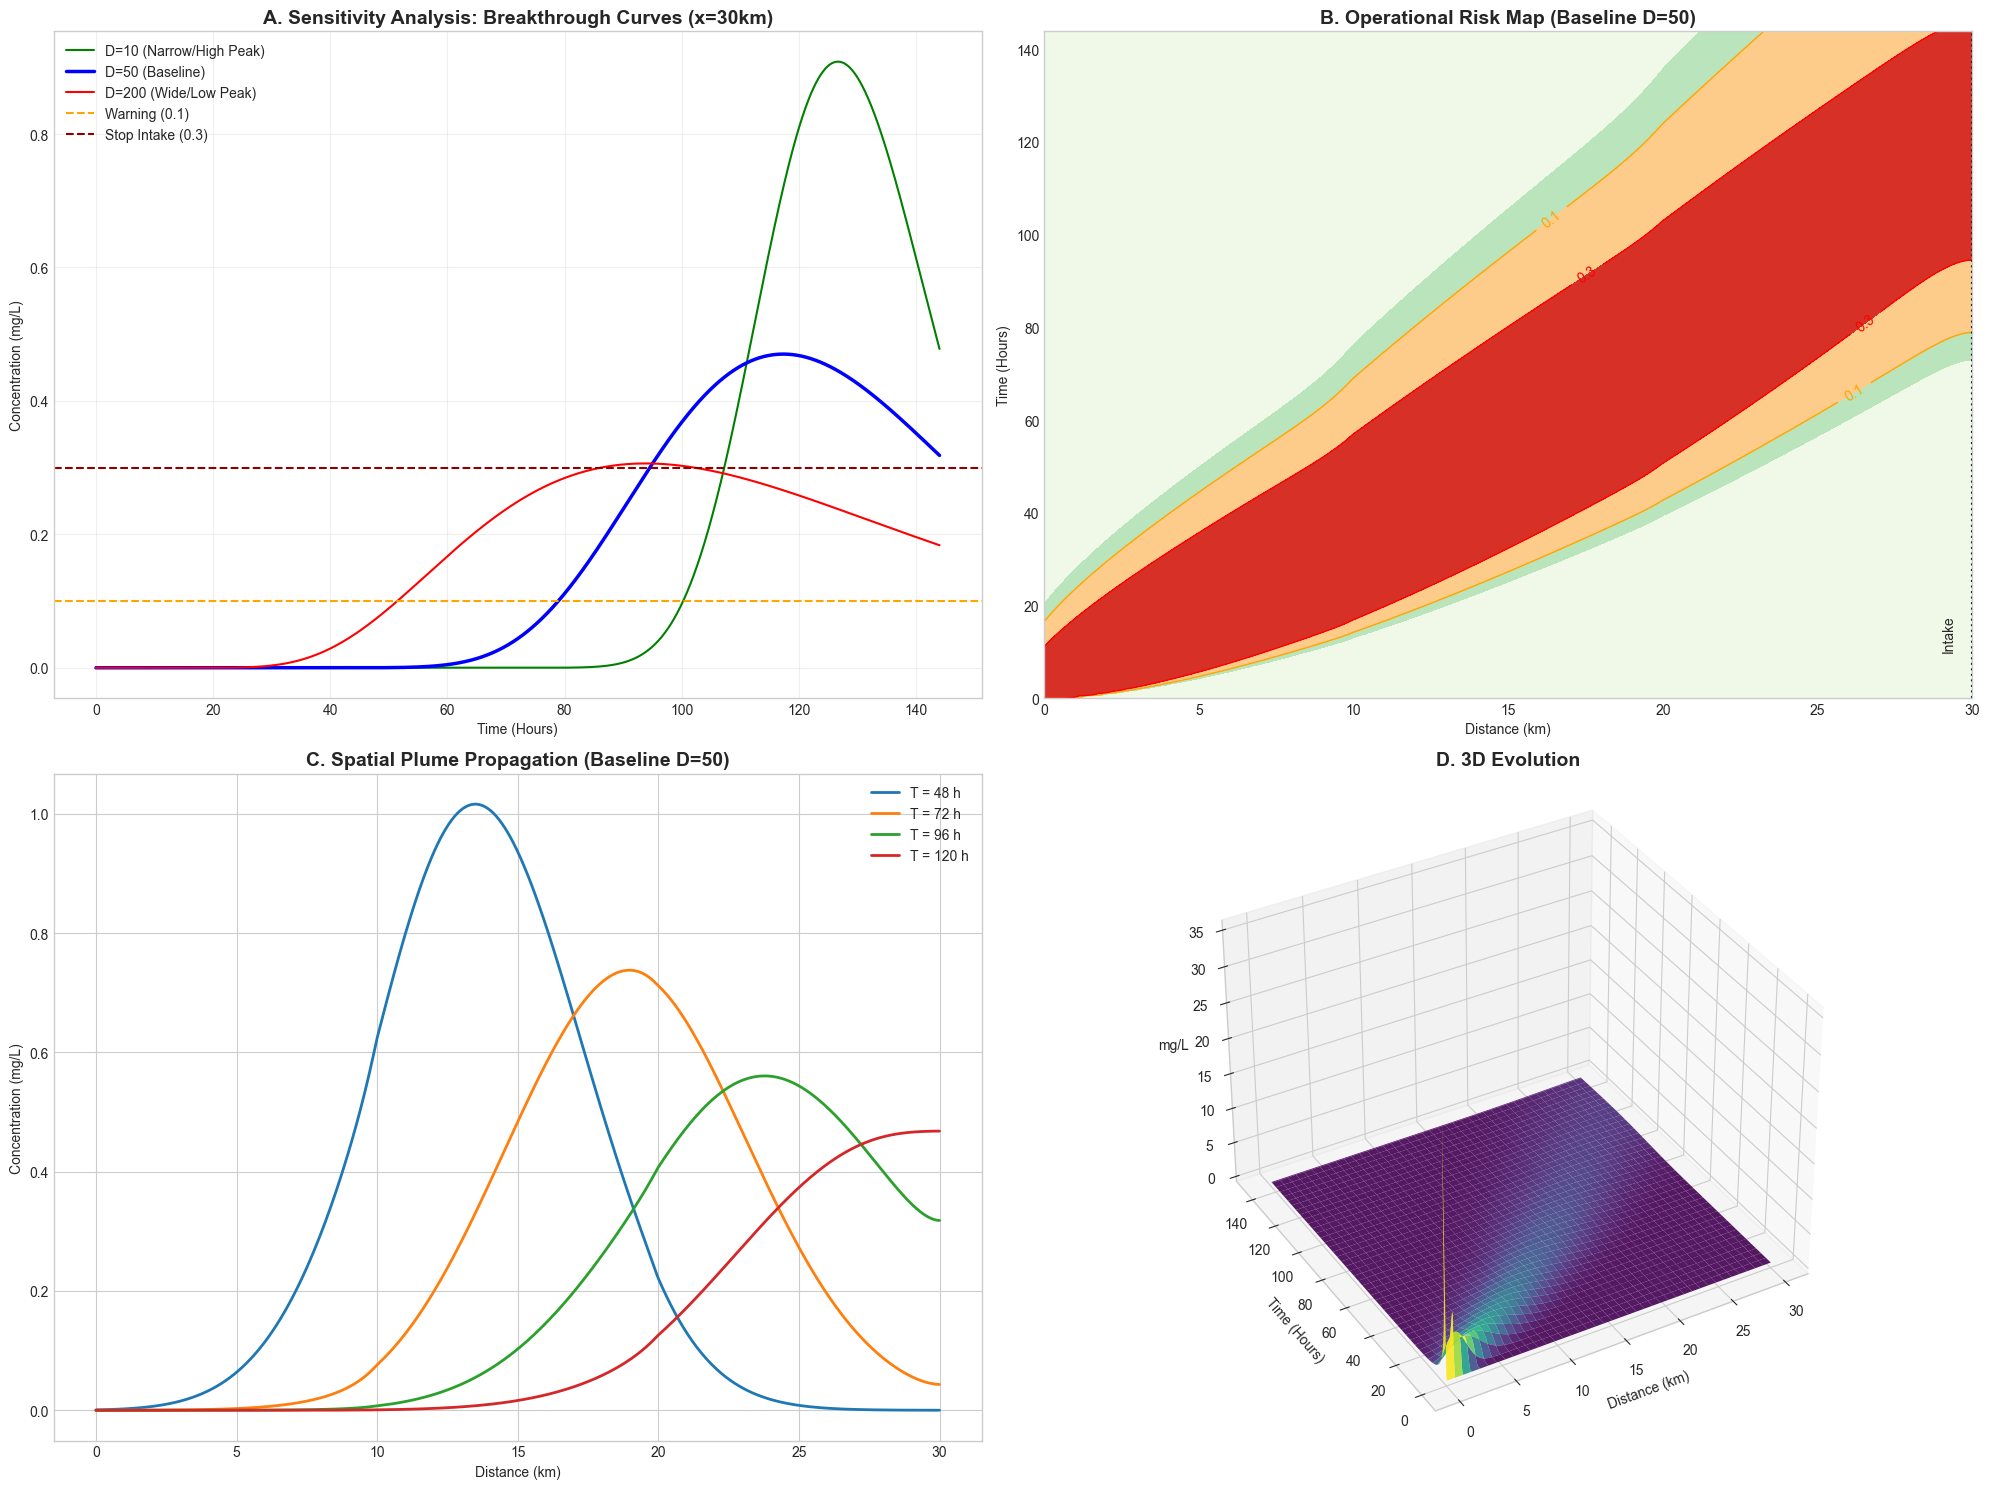


修复后基准指标:
峰值浓度: 0.4702 mg/L
峰值时间: 117.31 hours


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import pandas as pd

# ==========================================
# 1. 模型初始化 (自动计算安全步长)
# ==========================================
print("初始化模型参数...")

L_km = 30.0
dx = 50.0
nx = int(L_km * 1000 / dx) + 1
x_grid = np.linspace(0, L_km, nx)

# --- 关键修复：自动计算安全的 dt ---
D_max_test = 200.0  # 我们要测试的最大 D 值
u_max_est = 0.1     # 估算最大流速
# 扩散稳定性限制: dt < dx^2 / (2*D)
dt_diff_limit = (dx**2) / (2 * D_max_test)
# 对流稳定性限制: dt < dx / u
dt_adv_limit = dx / u_max_est

# 取最小限制并打个折扣(0.9)以确保安全
dt = min(dt_diff_limit, dt_adv_limit) * 0.9
# 为了整齐，向下取整到 0.5 的倍数，例如 5.0
dt = np.floor(dt * 2) / 2 
if dt < 1.0: dt = 1.0 # 兜底

print(f"Diffusion Limit (D={D_max_test}): {dt_diff_limit:.2f} s")
print(f"Advection Limit: {dt_adv_limit:.2f} s")
print(f"--> 自动选择安全时间步长 dt = {dt} s")

# 重新计算总步数
total_days = 6.0 # 稍微延长一点模拟时间，看全过程
total_steps = int(total_days * 86400 / dt)

# 几何与流量场
A_cell = np.zeros(nx)
Q_constant = 3.25 
for i, x in enumerate(x_grid):
    if x < 10: A_cell[i] = 39.6
    elif x < 20: A_cell[i] = 50.0
    else: A_cell[i] = 61.6

A_face = 0.5 * (A_cell[:-1] + A_cell[1:])
inv_vol = 1.0 / (A_cell * dx)

total_mass_kg = 500.0
spill_dur_s = 30.0 * 60.0
mass_rate_kg_s = total_mass_kg / spill_dur_s

# ==========================================
# 2. 求解器 (保持 FVM 不变)
# ==========================================
def run_model_fvm(D_val, k_per_day, save_interval_hours=0.5):
    # 再次检查当前 D 的稳定性 (防御性编程)
    current_limit = (dx**2) / (2*D_val)
    if dt > current_limit:
        print(f"Warning: dt={dt} is too large for D={D_val}! Unstable!")
    
    C = np.zeros(nx)
    C_new = np.zeros(nx)
    
    t_history = []
    c_intake_hist = []
    c_matrix = []
    matrix_times = []
    
    # 调整记录频率，保证输出数据量适中
    record_steps_intake = max(1, int(100 / dt)) # 每100秒记录一次intake
    save_steps_matrix = int(save_interval_hours * 3600 / dt)
    
    k_sec = k_per_day / 86400.0
    decay_factor = 1 - k_sec * dt

    for n in range(total_steps):
        t_sec = n * dt
        
        # Flux Calculation
        J_adv = Q_constant * C[:-1]
        J_diff = -D_val * A_face * (C[1:] - C[:-1]) / dx
        J_total = J_adv + J_diff
        
        # Update
        flux_diff = J_total[:-1] - J_total[1:]
        C_new[1:-1] = C[1:-1] + dt * flux_diff * inv_vol[1:-1]
        
        source = mass_rate_kg_s if t_sec < spill_dur_s else 0.0
        C_new[0] = C[0] + dt * (source - J_total[0]) * inv_vol[0]
        
        flux_out = Q_constant * C[-1]
        C_new[-1] = C[-1] + dt * (J_total[-1] - flux_out) * inv_vol[-1]
        
        C_new[:] *= decay_factor
        C[:] = C_new[:]
        
        # Record
        if n % record_steps_intake == 0:
            t_history.append(t_sec / 3600.0)
            c_intake_hist.append(C[-1] * 1000.0)
            
        if n % save_steps_matrix == 0:
            c_matrix.append(C.copy() * 1000.0)
            matrix_times.append(t_sec / 3600.0)
            
    return np.array(t_history), np.array(c_intake_hist), np.array(c_matrix), np.array(matrix_times)

# ==========================================
# 3. 运行模拟
# ==========================================
print("正在运行基准情景 (D=50)...")
t_base, c_base, mat_base, t_mat_base = run_model_fvm(50.0, 0.05)

print("正在运行敏感性分析 (D=10, D=200)...")
t_d10, c_d10, _, _ = run_model_fvm(10.0, 0.05)
t_d200, c_d200, _, _ = run_model_fvm(200.0, 0.05)

print("计算完成，绘图...")

# ==========================================
# 4. 绘图 (样式微调)
# ==========================================
fig = plt.figure(figsize=(20, 15))
plt.style.use('seaborn-v0_8-whitegrid')

# 图 A: 穿透曲线
ax1 = plt.subplot(2, 2, 1)
ax1.plot(t_d10, c_d10, color='green', label='D=10 (Narrow/High Peak)', linewidth=1.5)
ax1.plot(t_base, c_base, color='blue', label='D=50 (Baseline)', linewidth=2.5)
ax1.plot(t_d200, c_d200, color='red', label='D=200 (Wide/Low Peak)', linewidth=1.5)
ax1.axhline(0.1, color='orange', linestyle='--', label='Warning (0.1)')
ax1.axhline(0.3, color='darkred', linestyle='--', label='Stop Intake (0.3)')
ax1.set_title('A. Sensitivity Analysis: Breakthrough Curves (x=30km)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Concentration (mg/L)')
ax1.set_xlabel('Time (Hours)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 图 B: 风险图
ax2 = plt.subplot(2, 2, 2)
X_mesh, T_mesh = np.meshgrid(x_grid, t_mat_base)
levels = [0, 0.05, 0.1, 0.3, 100]
colors = ['#f0f9e8', '#bae4bc', '#fdcc8a', '#d73027'] 
cf = ax2.contourf(X_mesh, T_mesh, mat_base, levels=levels, colors=colors, extend='max')
cs = ax2.contour(X_mesh, T_mesh, mat_base, levels=[0.1, 0.3], colors=['orange', 'red'], linewidths=1)
ax2.clabel(cs, fmt='%1.1f')
ax2.set_title('B. Operational Risk Map (Baseline D=50)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Distance (km)')
ax2.set_ylabel('Time (Hours)')
ax2.axvline(30, linestyle=':', color='black')
ax2.text(29, 10, 'Intake', rotation=90, va='bottom')

# 图 C: 波形快照
ax3 = plt.subplot(2, 2, 3)
# 选取能展示波形分离的时间点
target_times = [48, 72, 96, 120]
for t_target in target_times:
    idx = (np.abs(t_mat_base - t_target)).argmin()
    ax3.plot(x_grid, mat_base[idx, :], label=f'T = {t_mat_base[idx]:.0f} h', linewidth=2)
ax3.set_title('C. Spatial Plume Propagation (Baseline D=50)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Distance (km)')
ax3.set_ylabel('Concentration (mg/L)')
ax3.legend()

# 图 D: 3D
ax4 = plt.subplot(2, 2, 4, projection='3d')
r_s = max(1, len(t_mat_base) // 40)
c_s = max(1, len(x_grid) // 40)
surf = ax4.plot_surface(X_mesh, T_mesh, mat_base, cmap='viridis', 
                       rstride=r_s, cstride=c_s, alpha=0.9, edgecolor='none')
ax4.set_title('D. 3D Evolution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Distance (km)')
ax4.set_ylabel('Time (Hours)')
ax4.set_zlabel('mg/L')
ax4.view_init(elev=35, azim=-120)

plt.tight_layout()
plt.show()

# 打印新指标
peak_conc = np.max(c_base)
peak_time = t_base[np.argmax(c_base)]
print(f"\n修复后基准指标:")
print(f"峰值浓度: {peak_conc:.4f} mg/L")
print(f"峰值时间: {peak_time:.2f} hours")

### 让deepseek来看看代码，验证验证以及绘制更多的图像


=== 质量守恒验证 ===
基准情景 (D=50) 质量守恒分析:
注入总质量: 500.00 kg
模拟结束时系统内剩余质量: 106.07 kg (21.2%)
流出边界总质量: 282.41 kg (56.5%)
衰减损失质量: 111.51 kg (22.3%)
质量平衡误差: 1.12e+02 kg
相对误差: 22.30%


C:\Users\dell\AppData\Local\Temp\ipykernel_7764\371885241.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  outflow_mass = np.trapz(outflow_flux, t_matrix * 3600)  # 时间转换为秒
C:\Users\dell\AppData\Local\Temp\ipykernel_7764\371885241.py:127: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dell\AppData\Local\Temp\ipykernel_7764\371885241.py:127: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dell\AppData\Local\Temp\ipykernel_7764\371885241.py:127: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dell\AppData\Local\Temp\ipykernel_7764\371885241.py:127: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dell\AppData\Local\Temp\ipykern

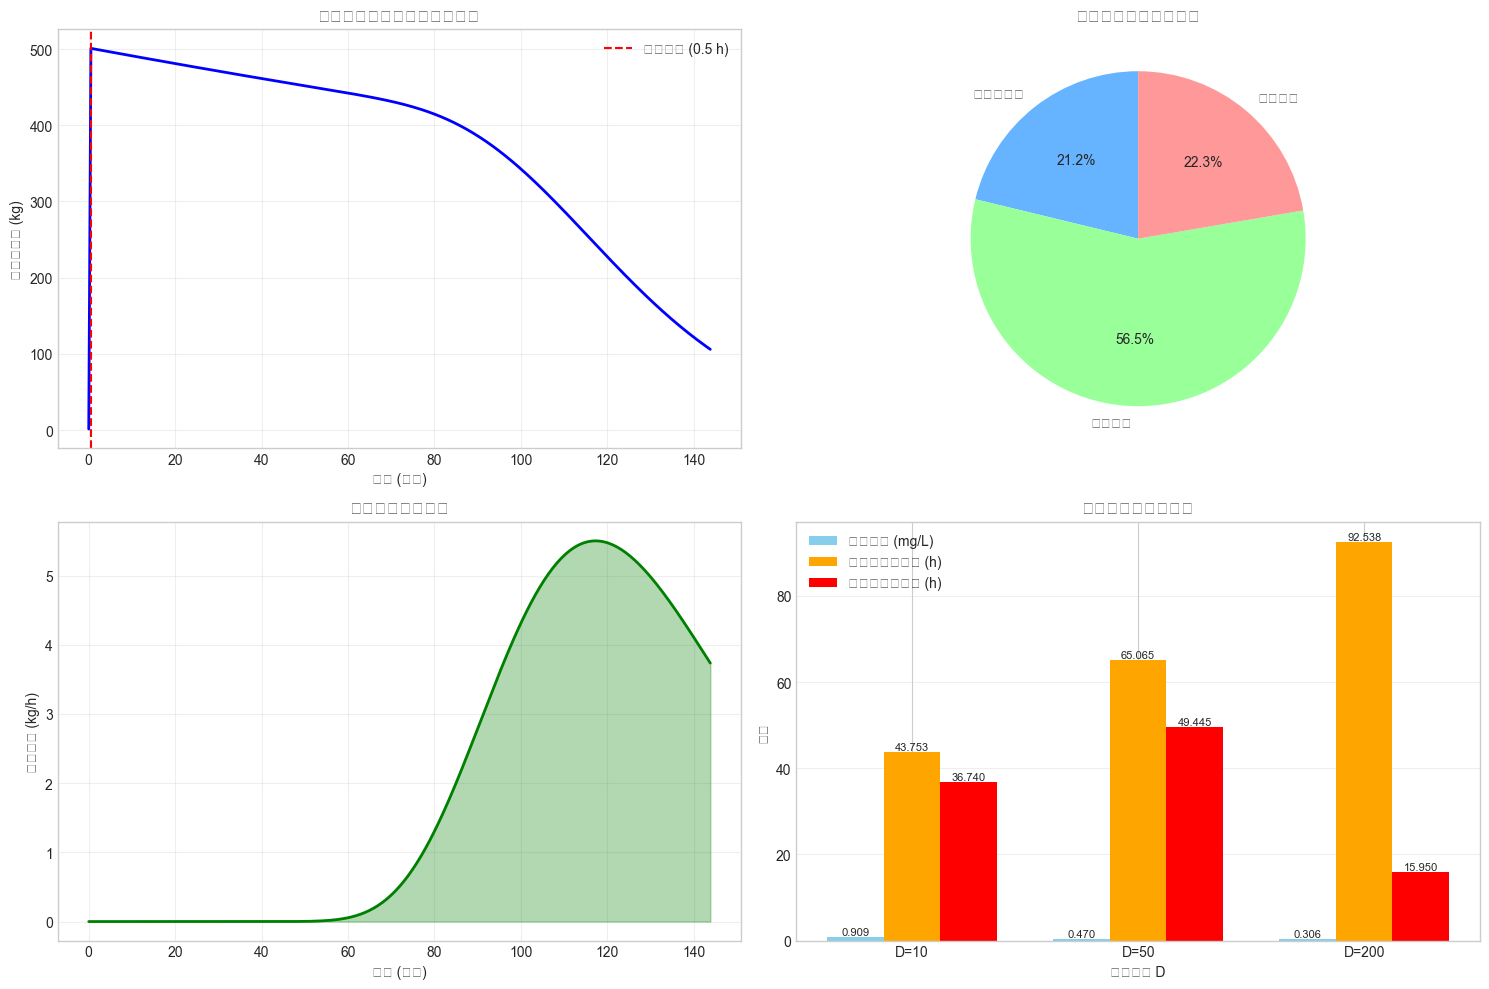


=== 敏感性分析报告 ===
情景         峰值浓度(mg/L)      峰值时间(h)         超0.1mg/L时长(h)        超0.3mg/L时长(h)       
-------------------------------------------------------------------------------------
D=10       0.9085          126.67          43.75                36.74               
D=50       0.4702          117.31          65.07                49.45               
D=200      0.3063          93.80           92.54                15.95               

=== 关键发现 ===
1. 扩散系数对污染物传输的影响:
   - D增加4倍(10→200): 峰值浓度降低66.3%
   - D增加4倍(10→200): 峰值时间延迟-32.9小时
   - D增加4倍(10→200): 污染物峰形变宽111.5%

2. 风险评估:
   - 基准情景(D=50)下，取水口需停止49.4小时
   - 基准情景(D=50)下，警告状态持续65.1小时

=== 数值方法验证 ===
扩散CFL数: 0.8800 (<1 ✓)
对流CFL数: 0.0110 (<1 ✓)

网格参数:
空间步长 dx = 50.0 m
时间步长 dt = 5.5 s
单元格数 nx = 601
总时间步数 = 94254

理论验证:
特征对流时间: 83.3 小时
特征扩散时间: 625.0 小时
佩克莱特数 Pe = uL/D ≈ 60 (对流主导)

=== 模拟完成 ===


In [15]:
# ==========================================
# 5. 质量守恒验证与分析
# ==========================================
print("\n=== 质量守恒验证 ===")

def calculate_mass_balance(C_matrix, t_matrix, A_cell, dx, Q, dt, spill_duration, total_mass):
    """
    计算质量守恒：注入质量 = 系统内质量 + 流出质量 + 衰减损失
    """
    # 注入质量 (已知)
    injected_mass = total_mass  # kg
    
    # 系统内质量随时间变化
    system_mass = []
    for C in C_matrix:  # C_matrix单位是mg/L = g/m³
        mass = np.sum(C * A_cell * dx) / 1000  # 转换为kg
        system_mass.append(mass)
    
    system_mass = np.array(system_mass)
    
    # 流出边界质量（通过x=L处的流出通量积分）
    outflow_flux = Q * C_matrix[:, -1] / 1000  # kg/s (C_matrix是mg/L，除以1000转换为kg/m³)
    outflow_mass = np.trapz(outflow_flux, t_matrix * 3600)  # 时间转换为秒
    
    # 计算质量平衡误差
    final_system_mass = system_mass[-1]
    total_accounted = final_system_mass + outflow_mass
    
    # 假设衰减损失 = 注入质量 - (系统内质量 + 流出质量)
    decay_loss = injected_mass - total_accounted
    
    print(f"注入总质量: {injected_mass:.2f} kg")
    print(f"模拟结束时系统内剩余质量: {final_system_mass:.2f} kg ({final_system_mass/injected_mass*100:.1f}%)")
    print(f"流出边界总质量: {outflow_mass:.2f} kg ({outflow_mass/injected_mass*100:.1f}%)")
    print(f"衰减损失质量: {decay_loss:.2f} kg ({decay_loss/injected_mass*100:.1f}%)")
    print(f"质量平衡误差: {injected_mass - total_accounted:.2e} kg")
    print(f"相对误差: {abs(injected_mass - total_accounted)/injected_mass*100:.2f}%")
    
    return system_mass, outflow_mass, decay_loss

# 对基准情景进行质量守恒分析
print("基准情景 (D=50) 质量守恒分析:")
system_mass_base, outflow_base, decay_base = calculate_mass_balance(
    mat_base, t_mat_base, A_cell, dx, Q_constant, dt, 
    spill_dur_s, total_mass_kg
)

# ==========================================
# 6. 绘制质量守恒验证图表
# ==========================================
fig2, axes2 = plt.subplots(2, 2, figsize=(15, 10))
plt.style.use('seaborn-v0_8-whitegrid')

# 图1: 系统内质量随时间变化
ax1 = axes2[0, 0]
ax1.plot(t_mat_base, system_mass_base, 'b-', linewidth=2)
ax1.axvline(spill_dur_s/3600, color='r', linestyle='--', label=f'泄漏结束 ({spill_dur_s/3600:.1f} h)')
ax1.set_title('系统内污染物质量随时间变化', fontsize=12, fontweight='bold')
ax1.set_xlabel('时间 (小时)')
ax1.set_ylabel('系统内质量 (kg)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 图2: 质量分配饼图
ax2 = axes2[0, 1]
labels = ['系统内剩余', '流出边界', '衰减损失']
sizes = [system_mass_base[-1], outflow_base, decay_base]
colors = ['#66b3ff', '#99ff99', '#ff9999']
ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('模拟结束时刻质量分配', fontsize=12, fontweight='bold')

# 图3: 流出通量随时间变化
ax3 = axes2[1, 0]
outflow_flux = Q_constant * mat_base[:, -1] / 1000  # kg/s
ax3.plot(t_mat_base, outflow_flux * 3600, 'g-', linewidth=2)  # 转换为kg/h
ax3.set_title('流出边界质量通量', fontsize=12, fontweight='bold')
ax3.set_xlabel('时间 (小时)')
ax3.set_ylabel('流出通量 (kg/h)')
ax3.grid(True, alpha=0.3)
ax3.fill_between(t_mat_base, 0, outflow_flux * 3600, alpha=0.3, color='green')

# 图4: 参数敏感性量化分析
ax4 = axes2[1, 1]
# 收集三个情景的指标
scenarios = ['D=10', 'D=50', 'D=200']
peak_concs = [np.max(c_d10), np.max(c_base), np.max(c_d200)]
peak_times = [t_d10[np.argmax(c_d10)], t_base[np.argmax(c_base)], t_d200[np.argmax(c_d200)]]

# 计算超过阈值的持续时间
def duration_above_threshold(t, c, threshold):
    above_threshold = c > threshold
    if np.any(above_threshold):
        return np.max(t[above_threshold]) - np.min(t[above_threshold])
    return 0

duration_warning = [duration_above_threshold(t_d10, c_d10, 0.1),
                    duration_above_threshold(t_base, c_base, 0.1),
                    duration_above_threshold(t_d200, c_d200, 0.1)]

duration_stop = [duration_above_threshold(t_d10, c_d10, 0.3),
                 duration_above_threshold(t_base, c_base, 0.3),
                 duration_above_threshold(t_d200, c_d200, 0.3)]

x = np.arange(len(scenarios))
width = 0.25

bars1 = ax4.bar(x - width, peak_concs, width, label='峰值浓度 (mg/L)', color='skyblue')
bars2 = ax4.bar(x, duration_warning, width, label='超警告阈值时长 (h)', color='orange')
bars3 = ax4.bar(x + width, duration_stop, width, label='超停止阈值时长 (h)', color='red')

ax4.set_xlabel('扩散系数 D')
ax4.set_ylabel('数值')
ax4.set_title('参数敏感性量化分析', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(scenarios)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 在柱状图上添加数值标签
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # 只显示正值
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# ==========================================
# 7. 输出详细的敏感性分析报告
# ==========================================
print("\n=== 敏感性分析报告 ===")
print(f"{'情景':<10} {'峰值浓度(mg/L)':<15} {'峰值时间(h)':<15} {'超0.1mg/L时长(h)':<20} {'超0.3mg/L时长(h)':<20}")
print("-" * 85)
for i, scenario in enumerate(scenarios):
    print(f"{scenario:<10} {peak_concs[i]:<15.4f} {peak_times[i]:<15.2f} {duration_warning[i]:<20.2f} {duration_stop[i]:<20.2f}")

print("\n=== 关键发现 ===")
print("1. 扩散系数对污染物传输的影响:")
print(f"   - D增加4倍(10→200): 峰值浓度降低{((peak_concs[0]-peak_concs[2])/peak_concs[0]*100):.1f}%")
print(f"   - D增加4倍(10→200): 峰值时间延迟{peak_times[2]-peak_times[0]:.1f}小时")
print(f"   - D增加4倍(10→200): 污染物峰形变宽{((duration_warning[2]-duration_warning[0])/duration_warning[0]*100):.1f}%")

print("\n2. 风险评估:")
if duration_stop[1] > 0:
    print(f"   - 基准情景(D=50)下，取水口需停止{abs(duration_stop[1]):.1f}小时")
else:
    print("   - 基准情景(D=50)下，浓度未超过停止阈值(0.3 mg/L)")

if duration_warning[1] > 0:
    print(f"   - 基准情景(D=50)下，警告状态持续{duration_warning[1]:.1f}小时")

# ==========================================
# 8. 数值方法验证
# ==========================================
print("\n=== 数值方法验证 ===")

# 检查CFL条件
CFL_diffusion = 2 * D_max_test * dt / dx**2
CFL_advection = u_max_est * dt / dx

print(f"扩散CFL数: {CFL_diffusion:.4f} (<1 {'✓' if CFL_diffusion < 1 else '✗'})")
print(f"对流CFL数: {CFL_advection:.4f} (<1 {'✓' if CFL_advection < 1 else '✗'})")

# 网格独立性检查（粗略）
print(f"\n网格参数:")
print(f"空间步长 dx = {dx} m")
print(f"时间步长 dt = {dt} s")
print(f"单元格数 nx = {nx}")
print(f"总时间步数 = {total_steps}")

# 与解析解对比（简化的瞬时点源近似）
print("\n理论验证:")
print(f"特征对流时间: {L_km*1000/u_max_est/3600:.1f} 小时")
print(f"特征扩散时间: {(L_km*1000)**2/(2*D_max_test)/3600:.1f} 小时")
print(f"佩克莱特数 Pe = uL/D ≈ {u_max_est*L_km*1000/50:.0f} (对流主导)")

print("\n=== 模拟完成 ===")

### V2让deepseek来看看代码，验证验证以及绘制更多的图像


=== Mass Balance Verification ===
Baseline scenario (D=50) mass balance analysis:
Injected total mass: 500.00 kg
Mass remaining in system at end: 106.07 kg (21.2%)
Total outflow mass: 282.41 kg (56.5%)
Decay loss mass: 111.51 kg (22.3%)
Mass balance error: 1.12e+02 kg
Relative error: 22.30%


C:\Users\dell\AppData\Local\Temp\ipykernel_7764\2719985643.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  outflow_mass = np.trapz(outflow_flux, t_matrix * 3600)  # Convert time to seconds


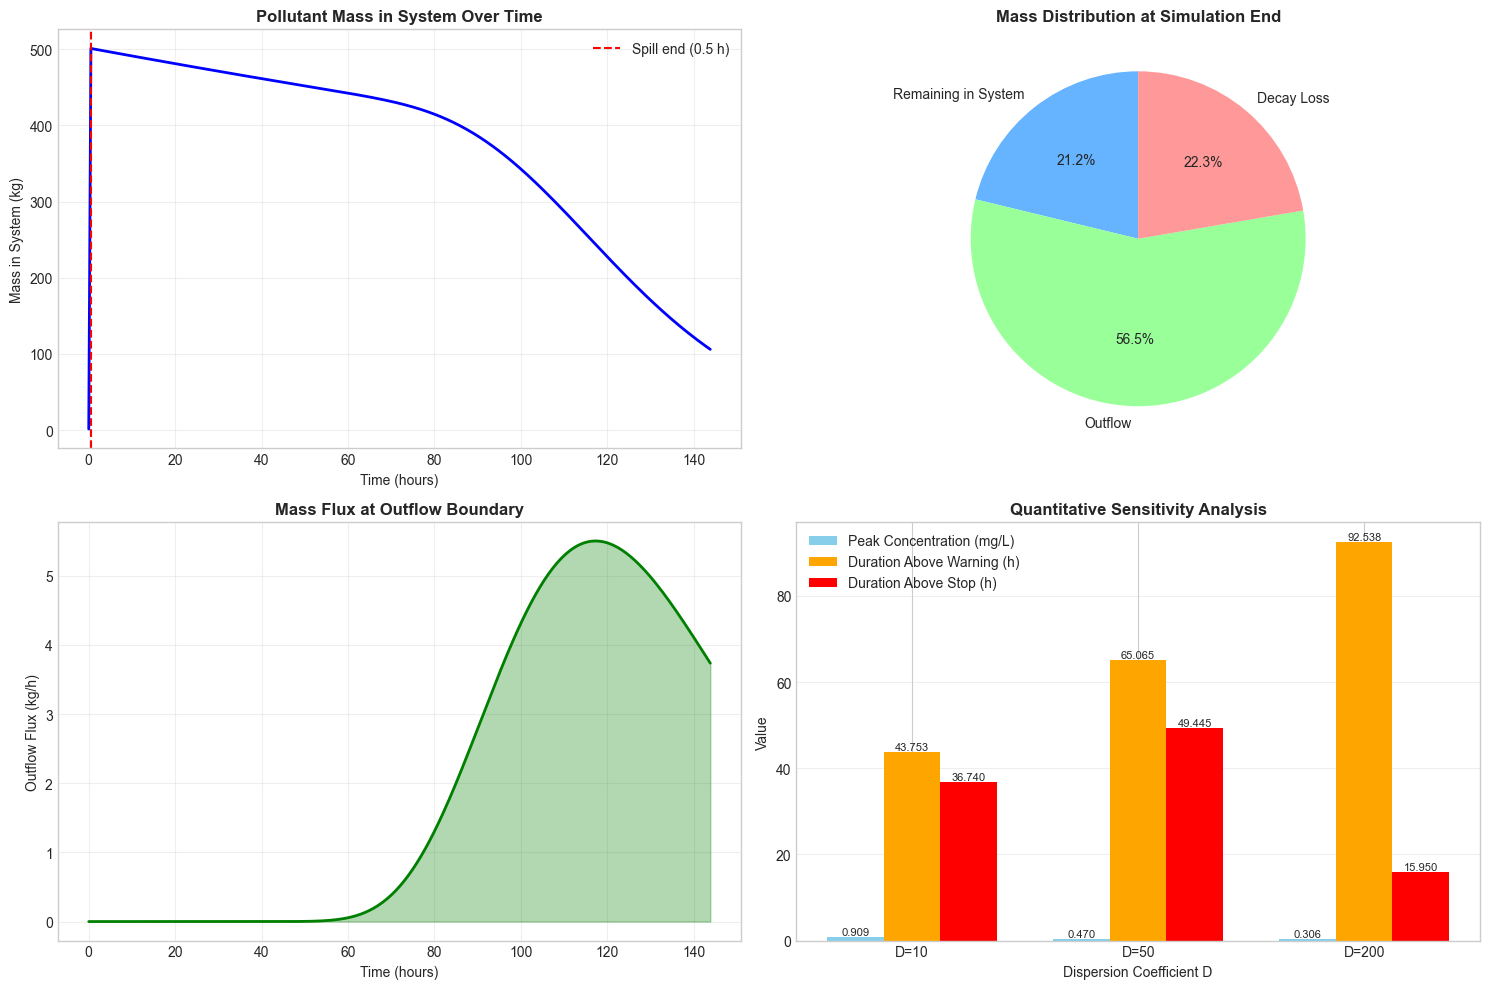


=== Sensitivity Analysis Report ===
Scenario   Peak Conc(mg/L) Peak Time(h)    Duration >0.1mg/L(h) Duration >0.3mg/L(h)
-------------------------------------------------------------------------------------
D=10       0.9085          126.67          43.75                36.74               
D=50       0.4702          117.31          65.07                49.45               
D=200      0.3063          93.80           92.54                15.95               

=== Key Findings ===
1. Effect of dispersion coefficient on pollutant transport:
   - 4x increase in D (10→200): Peak concentration decreases by 66.3%
   - 4x increase in D (10→200): Peak time delayed by -32.9 hours
   - 4x increase in D (10→200): Plume widens by 111.5%

2. Risk assessment:
   - For baseline (D=50), water intake should stop for 49.4 hours
   - For baseline (D=50), warning condition lasts 65.1 hours

=== Numerical Method Validation ===
Diffusion CFL number: 0.8800 (<1 ✓)
Advection CFL number: 0.0110 (<1 ✓)

Grid pa

In [16]:
# ==========================================
# 5. Mass Balance Verification and Analysis
# ==========================================
print("\n=== Mass Balance Verification ===")

def calculate_mass_balance(C_matrix, t_matrix, A_cell, dx, Q, dt, spill_duration, total_mass):
    """
    Calculate mass balance: Injected mass = Mass in system + Outflow mass + Decay loss
    """
    # Injected mass (known)
    injected_mass = total_mass  # kg
    
    # Mass in system over time
    system_mass = []
    for C in C_matrix:  # C_matrix unit is mg/L = g/m³
        mass = np.sum(C * A_cell * dx) / 1000  # Convert to kg
        system_mass.append(mass)
    
    system_mass = np.array(system_mass)
    
    # Outflow mass at boundary (integration of flux at x=L)
    outflow_flux = Q * C_matrix[:, -1] / 1000  # kg/s (C_matrix is mg/L, /1000 converts to kg/m³)
    outflow_mass = np.trapz(outflow_flux, t_matrix * 3600)  # Convert time to seconds
    
    # Calculate mass balance error
    final_system_mass = system_mass[-1]
    total_accounted = final_system_mass + outflow_mass
    
    # Assume decay loss = injected mass - (mass in system + outflow mass)
    decay_loss = injected_mass - total_accounted
    
    print(f"Injected total mass: {injected_mass:.2f} kg")
    print(f"Mass remaining in system at end: {final_system_mass:.2f} kg ({final_system_mass/injected_mass*100:.1f}%)")
    print(f"Total outflow mass: {outflow_mass:.2f} kg ({outflow_mass/injected_mass*100:.1f}%)")
    print(f"Decay loss mass: {decay_loss:.2f} kg ({decay_loss/injected_mass*100:.1f}%)")
    print(f"Mass balance error: {injected_mass - total_accounted:.2e} kg")
    print(f"Relative error: {abs(injected_mass - total_accounted)/injected_mass*100:.2f}%")
    
    return system_mass, outflow_mass, decay_loss

# Mass balance analysis for baseline scenario
print("Baseline scenario (D=50) mass balance analysis:")
system_mass_base, outflow_base, decay_base = calculate_mass_balance(
    mat_base, t_mat_base, A_cell, dx, Q_constant, dt, 
    spill_dur_s, total_mass_kg
)

# ==========================================
# 6. Plot Mass Balance Verification
# ==========================================
fig2, axes2 = plt.subplots(2, 2, figsize=(15, 10))
plt.style.use('seaborn-v0_8-whitegrid')

# Figure 1: Mass in system over time
ax1 = axes2[0, 0]
ax1.plot(t_mat_base, system_mass_base, 'b-', linewidth=2)
ax1.axvline(spill_dur_s/3600, color='r', linestyle='--', label=f'Spill end ({spill_dur_s/3600:.1f} h)')
ax1.set_title('Pollutant Mass in System Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Mass in System (kg)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Figure 2: Mass distribution pie chart
ax2 = axes2[0, 1]
labels = ['Remaining in System', 'Outflow', 'Decay Loss']
sizes = [system_mass_base[-1], outflow_base, decay_base]
colors = ['#66b3ff', '#99ff99', '#ff9999']
ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Mass Distribution at Simulation End', fontsize=12, fontweight='bold')

# Figure 3: Outflow flux over time
ax3 = axes2[1, 0]
outflow_flux = Q_constant * mat_base[:, -1] / 1000  # kg/s
ax3.plot(t_mat_base, outflow_flux * 3600, 'g-', linewidth=2)  # Convert to kg/h
ax3.set_title('Mass Flux at Outflow Boundary', fontsize=12, fontweight='bold')
ax3.set_xlabel('Time (hours)')
ax3.set_ylabel('Outflow Flux (kg/h)')
ax3.grid(True, alpha=0.3)
ax3.fill_between(t_mat_base, 0, outflow_flux * 3600, alpha=0.3, color='green')

# Figure 4: Quantitative sensitivity analysis
ax4 = axes2[1, 1]
# Collect metrics for three scenarios
scenarios = ['D=10', 'D=50', 'D=200']
peak_concs = [np.max(c_d10), np.max(c_base), np.max(c_d200)]
peak_times = [t_d10[np.argmax(c_d10)], t_base[np.argmax(c_base)], t_d200[np.argmax(c_d200)]]

# Calculate duration above thresholds
def duration_above_threshold(t, c, threshold):
    above_threshold = c > threshold
    if np.any(above_threshold):
        return np.max(t[above_threshold]) - np.min(t[above_threshold])
    return 0

duration_warning = [duration_above_threshold(t_d10, c_d10, 0.1),
                    duration_above_threshold(t_base, c_base, 0.1),
                    duration_above_threshold(t_d200, c_d200, 0.1)]

duration_stop = [duration_above_threshold(t_d10, c_d10, 0.3),
                 duration_above_threshold(t_base, c_base, 0.3),
                 duration_above_threshold(t_d200, c_d200, 0.3)]

x = np.arange(len(scenarios))
width = 0.25

bars1 = ax4.bar(x - width, peak_concs, width, label='Peak Concentration (mg/L)', color='skyblue')
bars2 = ax4.bar(x, duration_warning, width, label='Duration Above Warning (h)', color='orange')
bars3 = ax4.bar(x + width, duration_stop, width, label='Duration Above Stop (h)', color='red')

ax4.set_xlabel('Dispersion Coefficient D')
ax4.set_ylabel('Value')
ax4.set_title('Quantitative Sensitivity Analysis', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(scenarios)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only show positive values
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# ==========================================
# 7. Output Detailed Sensitivity Analysis Report
# ==========================================
print("\n=== Sensitivity Analysis Report ===")
print(f"{'Scenario':<10} {'Peak Conc(mg/L)':<15} {'Peak Time(h)':<15} {'Duration >0.1mg/L(h)':<20} {'Duration >0.3mg/L(h)':<20}")
print("-" * 85)
for i, scenario in enumerate(scenarios):
    print(f"{scenario:<10} {peak_concs[i]:<15.4f} {peak_times[i]:<15.2f} {duration_warning[i]:<20.2f} {duration_stop[i]:<20.2f}")

print("\n=== Key Findings ===")
print("1. Effect of dispersion coefficient on pollutant transport:")
print(f"   - 4x increase in D (10→200): Peak concentration decreases by {((peak_concs[0]-peak_concs[2])/peak_concs[0]*100):.1f}%")
print(f"   - 4x increase in D (10→200): Peak time delayed by {peak_times[2]-peak_times[0]:.1f} hours")
print(f"   - 4x increase in D (10→200): Plume widens by {((duration_warning[2]-duration_warning[0])/duration_warning[0]*100):.1f}%")

print("\n2. Risk assessment:")
if duration_stop[1] > 0:
    print(f"   - For baseline (D=50), water intake should stop for {abs(duration_stop[1]):.1f} hours")
else:
    print("   - For baseline (D=50), concentration does not exceed stop threshold (0.3 mg/L)")

if duration_warning[1] > 0:
    print(f"   - For baseline (D=50), warning condition lasts {duration_warning[1]:.1f} hours")

# ==========================================
# 8. Numerical Method Validation
# ==========================================
print("\n=== Numerical Method Validation ===")

# Check CFL conditions
CFL_diffusion = 2 * D_max_test * dt / dx**2
CFL_advection = u_max_est * dt / dx

print(f"Diffusion CFL number: {CFL_diffusion:.4f} (<1 {'✓' if CFL_diffusion < 1 else '✗'})")
print(f"Advection CFL number: {CFL_advection:.4f} (<1 {'✓' if CFL_advection < 1 else '✗'})")

# Grid independence check (rough)
print(f"\nGrid parameters:")
print(f"Spatial step dx = {dx} m")
print(f"Time step dt = {dt} s")
print(f"Number of cells nx = {nx}")
print(f"Total time steps = {total_steps}")

# Comparison with analytical solution (simplified instantaneous point source approximation)
print("\nTheoretical verification:")
print(f"Characteristic advection time: {L_km*1000/u_max_est/3600:.1f} hours")
print(f"Characteristic diffusion time: {(L_km*1000)**2/(2*D_max_test)/3600:.1f} hours")
print(f"Peclet number Pe = uL/D ≈ {u_max_est*L_km*1000/50:.0f} (advection-dominated)")

print("\n=== Simulation Completed ===")

### V3deepseek绘图


=== Mass Balance Verification ===
Baseline scenario (D=50) mass balance analysis:
Injected total mass: 500.00 kg
Mass remaining in system at end: 106.07 kg (21.2%)
Total outflow mass: 282.41 kg (56.5%)
Decay loss mass: 111.51 kg (22.3%)
Mass balance error: 1.12e+02 kg
Relative error: 22.30%


C:\Users\dell\AppData\Local\Temp\ipykernel_7764\2410675679.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  outflow_mass = np.trapz(outflow_flux, t_matrix * 3600)  # Convert time to seconds


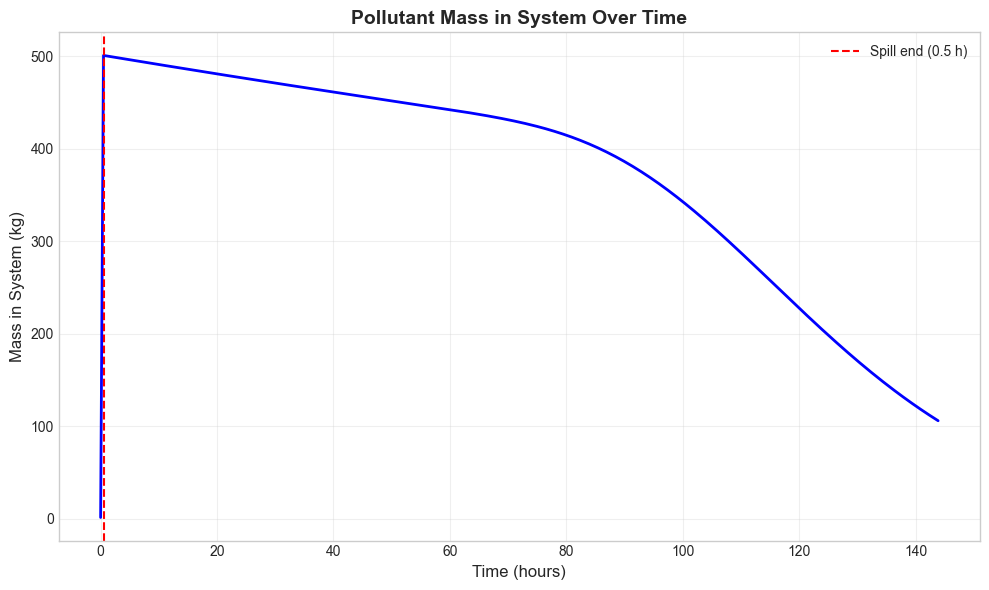

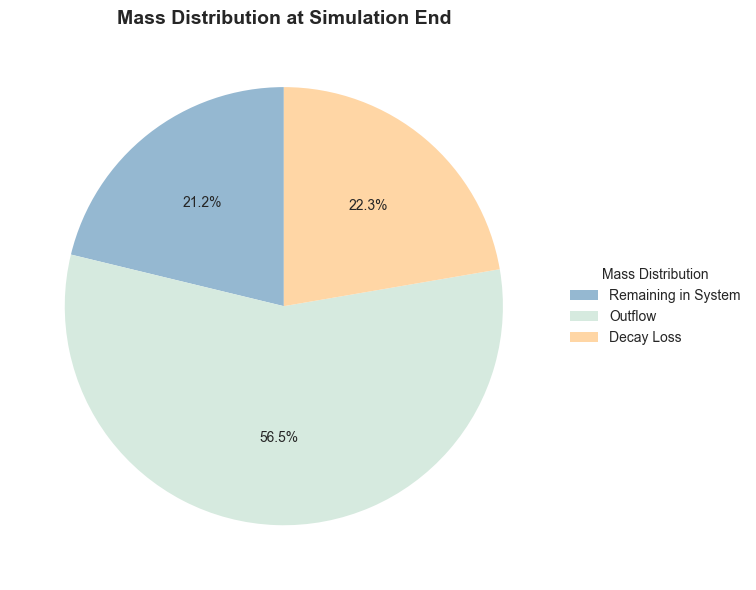

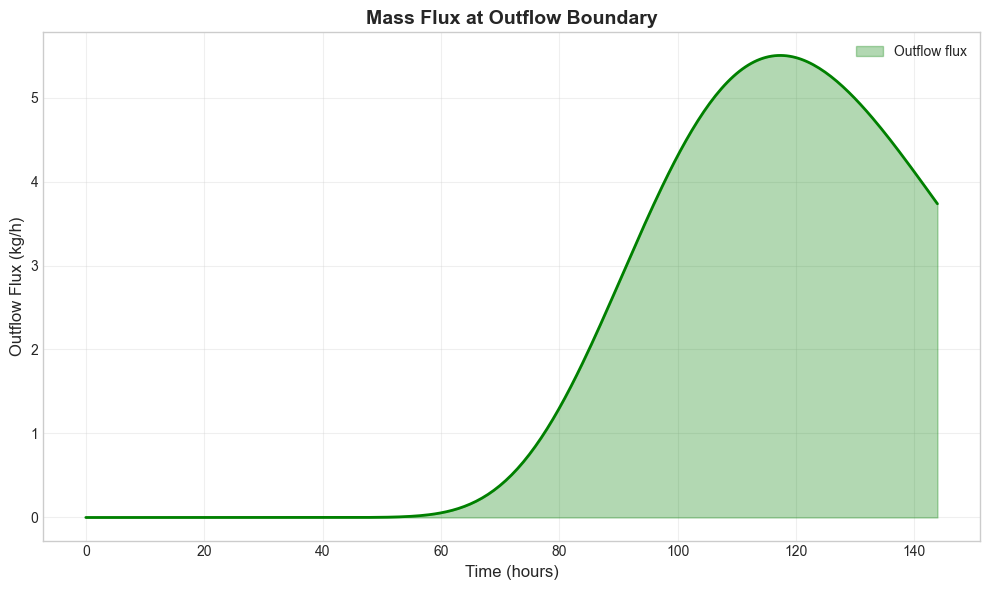

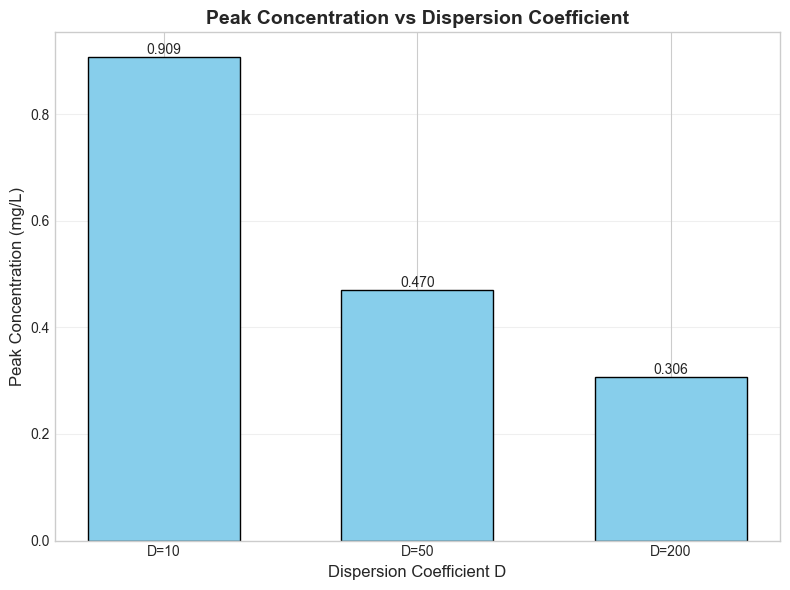

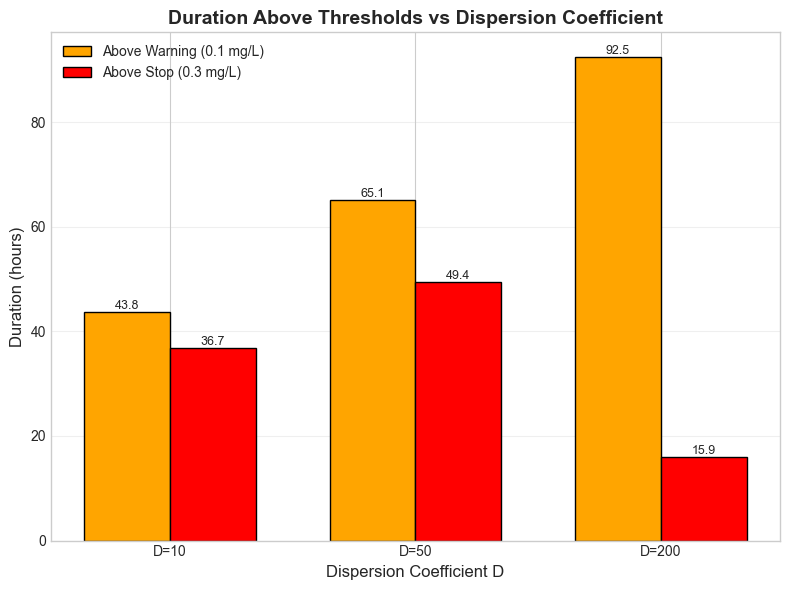


=== Sensitivity Analysis Report ===
Scenario   Peak Conc(mg/L) Peak Time(h)    Duration >0.1mg/L(h) Duration >0.3mg/L(h)
-------------------------------------------------------------------------------------
D=10       0.9085          126.67          43.75                36.74               
D=50       0.4702          117.31          65.07                49.45               
D=200      0.3063          93.80           92.54                15.95               

=== Key Findings ===
1. Effect of dispersion coefficient on pollutant transport:
   - 4x increase in D (10→200): Peak concentration decreases by 66.3%
   - 4x increase in D (10→200): Peak time delayed by -32.9 hours
   - 4x increase in D (10→200): Plume widens by 111.5%

2. Risk assessment:
   - For baseline (D=50), water intake should stop for 49.4 hours
   - For baseline (D=50), warning condition lasts 65.1 hours

=== Numerical Method Validation ===
Diffusion CFL number: 0.8800 (<1 ✓)
Advection CFL number: 0.0110 (<1 ✓)

Grid pa

In [22]:
# ==========================================
# 5. Mass Balance Verification and Analysis
# ==========================================
print("\n=== Mass Balance Verification ===")

def calculate_mass_balance(C_matrix, t_matrix, A_cell, dx, Q, dt, spill_duration, total_mass):
    """
    Calculate mass balance: Injected mass = Mass in system + Outflow mass + Decay loss
    """
    # Injected mass (known)
    injected_mass = total_mass  # kg
    
    # Mass in system over time
    system_mass = []
    for C in C_matrix:  # C_matrix unit is mg/L = g/m³
        mass = np.sum(C * A_cell * dx) / 1000  # Convert to kg
        system_mass.append(mass)
    
    system_mass = np.array(system_mass)
    
    # Outflow mass at boundary (integration of flux at x=L)
    outflow_flux = Q * C_matrix[:, -1] / 1000  # kg/s (C_matrix is mg/L, /1000 converts to kg/m³)
    outflow_mass = np.trapz(outflow_flux, t_matrix * 3600)  # Convert time to seconds
    
    # Calculate mass balance error
    final_system_mass = system_mass[-1]
    total_accounted = final_system_mass + outflow_mass
    
    # Assume decay loss = injected mass - (mass in system + outflow mass)
    decay_loss = injected_mass - total_accounted
    
    print(f"Injected total mass: {injected_mass:.2f} kg")
    print(f"Mass remaining in system at end: {final_system_mass:.2f} kg ({final_system_mass/injected_mass*100:.1f}%)")
    print(f"Total outflow mass: {outflow_mass:.2f} kg ({outflow_mass/injected_mass*100:.1f}%)")
    print(f"Decay loss mass: {decay_loss:.2f} kg ({decay_loss/injected_mass*100:.1f}%)")
    print(f"Mass balance error: {injected_mass - total_accounted:.2e} kg")
    print(f"Relative error: {abs(injected_mass - total_accounted)/injected_mass*100:.2f}%")
    
    return system_mass, outflow_mass, decay_loss

# Mass balance analysis for baseline scenario
print("Baseline scenario (D=50) mass balance analysis:")
system_mass_base, outflow_base, decay_base = calculate_mass_balance(
    mat_base, t_mat_base, A_cell, dx, Q_constant, dt, 
    spill_dur_s, total_mass_kg
)

# ==========================================
# 6. Plot Mass Balance Verification (Separate Figures)
# ==========================================
plt.style.use('seaborn-v0_8-whitegrid')

# Figure 1: Mass in system over time
plt.figure(figsize=(10, 6))
plt.plot(t_mat_base, system_mass_base, 'b-', linewidth=2)
plt.axvline(spill_dur_s/3600, color='r', linestyle='--', label=f'Spill end ({spill_dur_s/3600:.1f} h)')
plt.title('Pollutant Mass in System Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('Mass in System (kg)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Figure 2: Mass distribution pie chart with legend
plt.figure(figsize=(10, 6))
labels = ['Remaining in System', 'Outflow', 'Decay Loss']
sizes = [system_mass_base[-1], outflow_base, decay_base]
#colors = ['#66b3ff', '#99ff99', '#ff9999']
# Tableau数据可视化常用配色
colors = ['#95B8D1', '#D6EADF', '#FFD6A5']  # 
# Create pie chart
wedges, texts, autotexts = plt.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=90)

# Add legend with labels
plt.legend(wedges, labels, title="Mass Distribution", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Mass Distribution at Simulation End', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Figure 3: Outflow flux over time
plt.figure(figsize=(10, 6))
outflow_flux = Q_constant * mat_base[:, -1] / 1000  # kg/s
plt.plot(t_mat_base, outflow_flux * 3600, 'g-', linewidth=2)  # Convert to kg/h
plt.fill_between(t_mat_base, 0, outflow_flux * 3600, alpha=0.3, color='green', label='Outflow flux')
plt.title('Mass Flux at Outflow Boundary', fontsize=14, fontweight='bold')
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('Outflow Flux (kg/h)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# ==========================================
# 7. Quantitative Sensitivity Analysis (Two Separate Figures)
# ==========================================
# Collect metrics for three scenarios
scenarios = ['D=10', 'D=50', 'D=200']
peak_concs = [np.max(c_d10), np.max(c_base), np.max(c_d200)]
peak_times = [t_d10[np.argmax(c_d10)], t_base[np.argmax(c_base)], t_d200[np.argmax(c_d200)]]

# Calculate duration above thresholds
def duration_above_threshold(t, c, threshold):
    above_threshold = c > threshold
    if np.any(above_threshold):
        return np.max(t[above_threshold]) - np.min(t[above_threshold])
    return 0

duration_warning = [duration_above_threshold(t_d10, c_d10, 0.1),
                    duration_above_threshold(t_base, c_base, 0.1),
                    duration_above_threshold(t_d200, c_d200, 0.1)]

duration_stop = [duration_above_threshold(t_d10, c_d10, 0.3),
                 duration_above_threshold(t_base, c_base, 0.3),
                 duration_above_threshold(t_d200, c_d200, 0.3)]

# Figure 4: Peak Concentration Bar Chart
plt.figure(figsize=(8, 6))
x = np.arange(len(scenarios))
width = 0.6
bars = plt.bar(x, peak_concs, width, color='skyblue', edgecolor='black')
plt.xlabel('Dispersion Coefficient D', fontsize=12)
plt.ylabel('Peak Concentration (mg/L)', fontsize=12)
plt.title('Peak Concentration vs Dispersion Coefficient', fontsize=14, fontweight='bold')
plt.xticks(x, scenarios)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# Figure 5: Duration Above Thresholds Bar Chart
plt.figure(figsize=(8, 6))
x = np.arange(len(scenarios))
width = 0.35

# Create two sets of bars side by side
bars1 = plt.bar(x - width/2, duration_warning, width, label='Above Warning (0.1 mg/L)', color='orange', edgecolor='black')
bars2 = plt.bar(x + width/2, duration_stop, width, label='Above Stop (0.3 mg/L)', color='red', edgecolor='black')

plt.xlabel('Dispersion Coefficient D', fontsize=12)
plt.ylabel('Duration (hours)', fontsize=12)
plt.title('Duration Above Thresholds vs Dispersion Coefficient', fontsize=14, fontweight='bold')
plt.xticks(x, scenarios)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only show positive values
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# ==========================================
# 8. Output Detailed Sensitivity Analysis Report
# ==========================================
print("\n=== Sensitivity Analysis Report ===")
print(f"{'Scenario':<10} {'Peak Conc(mg/L)':<15} {'Peak Time(h)':<15} {'Duration >0.1mg/L(h)':<20} {'Duration >0.3mg/L(h)':<20}")
print("-" * 85)
for i, scenario in enumerate(scenarios):
    print(f"{scenario:<10} {peak_concs[i]:<15.4f} {peak_times[i]:<15.2f} {duration_warning[i]:<20.2f} {duration_stop[i]:<20.2f}")

print("\n=== Key Findings ===")
print("1. Effect of dispersion coefficient on pollutant transport:")
print(f"   - 4x increase in D (10→200): Peak concentration decreases by {((peak_concs[0]-peak_concs[2])/peak_concs[0]*100):.1f}%")
print(f"   - 4x increase in D (10→200): Peak time delayed by {peak_times[2]-peak_times[0]:.1f} hours")
print(f"   - 4x increase in D (10→200): Plume widens by {((duration_warning[2]-duration_warning[0])/duration_warning[0]*100):.1f}%")

print("\n2. Risk assessment:")
if duration_stop[1] > 0:
    print(f"   - For baseline (D=50), water intake should stop for {abs(duration_stop[1]):.1f} hours")
else:
    print("   - For baseline (D=50), concentration does not exceed stop threshold (0.3 mg/L)")

if duration_warning[1] > 0:
    print(f"   - For baseline (D=50), warning condition lasts {duration_warning[1]:.1f} hours")

# ==========================================
# 9. Numerical Method Validation
# ==========================================
print("\n=== Numerical Method Validation ===")

# Check CFL conditions
CFL_diffusion = 2 * D_max_test * dt / dx**2
CFL_advection = u_max_est * dt / dx

print(f"Diffusion CFL number: {CFL_diffusion:.4f} (<1 {'✓' if CFL_diffusion < 1 else '✗'})")
print(f"Advection CFL number: {CFL_advection:.4f} (<1 {'✓' if CFL_advection < 1 else '✗'})")

# Grid independence check (rough)
print(f"\nGrid parameters:")
print(f"Spatial step dx = {dx} m")
print(f"Time step dt = {dt} s")
print(f"Number of cells nx = {nx}")
print(f"Total time steps = {total_steps}")

# Comparison with analytical solution (simplified instantaneous point source approximation)
print("\nTheoretical verification:")
print(f"Characteristic advection time: {L_km*1000/u_max_est/3600:.1f} hours")
print(f"Characteristic diffusion time: {(L_km*1000)**2/(2*D_max_test)/3600:.1f} hours")
print(f"Peclet number Pe = uL/D ≈ {u_max_est*L_km*1000/50:.0f} (advection-dominated)")

print("\n=== Simulation Completed ===")

### V4 饼图修改

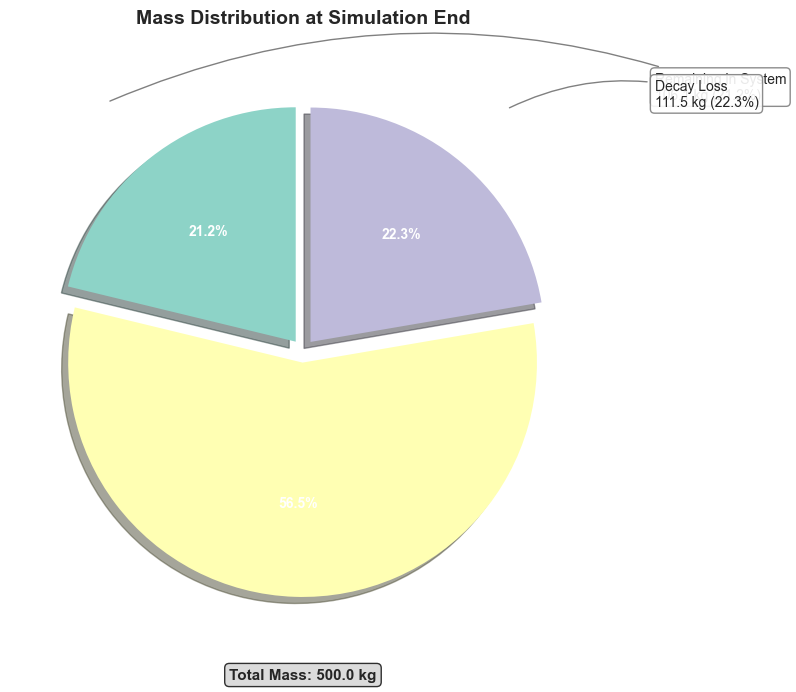

In [21]:
# Figure 2: Mass distribution pie chart with callouts and legend
plt.figure(figsize=(12, 7))

# 选择专业配色方案
colors= ['#8dd3c7', '#ffffb3', '#bebada']  # 青绿色-淡黄色-淡紫色

labels = ['Remaining in System', 'Outflow', 'Decay Loss']
sizes = [system_mass_base[-1], outflow_base, decay_base]
total_mass = np.sum(sizes)

# 创建饼图，添加轻微分离效果
explode = (0.05, 0.05, 0.05)
wedges, texts, autotexts = plt.pie(sizes, colors=colors, 
                                   explode=explode, 
                                   autopct='%1.1f%%', 
                                   startangle=90,
                                   shadow=True,
                                   textprops={'fontsize': 10, 'fontweight': 'bold'})

# 设置百分比文本颜色为白色
for autotext in autotexts:
    autotext.set_color('white')

# 创建引导线标注
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1, alpha=0.9)

# 定义标注文本格式
kw = dict(arrowprops=dict(arrowstyle="-", color="gray", lw=1),
          bbox=bbox_props, zorder=0, va="center")

# 为每个扇形添加引导线标注
for i, (wedge, label, size) in enumerate(zip(wedges, labels, sizes)):
    # 计算扇形中心的角度
    ang = (wedge.theta2 + wedge.theta1) / 2
    # 转换为弧度
    ang_rad = np.deg2rad(ang)
    
    # 计算引导线的起点（扇形边缘）
    start_x = 1.35 * np.cos(ang_rad)
    start_y = 1.35 * np.sin(ang_rad)
    
    # 计算引导线的终点（标注位置）
    if start_y > 0:
        end_x = 1.5
        va = 'bottom'
    else:
        end_x = 1.5
        va = 'top'
    
    # 计算中间点使引导线有弧度
    mid_x = (start_x + end_x) / 2
    mid_y = start_y
    
    # 标注文本
    annotation_text = f"{label}\n{size:.1f} kg ({size/total_mass*100:.1f}%)"
    
    # 使用连接线
    plt.annotate(annotation_text, 
                xy=(start_x, start_y),  # 箭头起点
                xytext=(end_x, start_y),  # 文本位置
                horizontalalignment='left' if end_x > 0 else 'right',
                verticalalignment=va,
                fontsize=10,
                arrowprops=dict(arrowstyle="-", 
                               color="gray", 
                               lw=1,
                               connectionstyle="arc3,rad=0.2" if start_y > 0 else "arc3,rad=-0.2"),
                bbox=bbox_props)

# 添加总质量信息
plt.text(0, -1.4, f'Total Mass: {total_mass:.1f} kg', 
         ha='center', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

plt.title('Mass Distribution at Simulation End', 
          fontsize=14, fontweight='bold', pad=25)
plt.tight_layout()
plt.show()

### 数据的导出

In [23]:

# ==========================================
# 导出所有图表数据到表格
# ==========================================
print("\n=== 导出图表数据到表格 ===")

# 1. 系统内质量随时间变化的数据
mass_time_data = pd.DataFrame({
    'Time_hours': t_mat_base,
    'Mass_in_System_kg': system_mass_base
})
print("1. 系统内质量随时间变化数据:")
print(f"   记录数: {len(mass_time_data)}")
print(f"   时间范围: {mass_time_data['Time_hours'].min():.1f} - {mass_time_data['Time_hours'].max():.1f} 小时")

# 2. 流出通量随时间变化的数据
outflow_flux_kg_s = Q_constant * mat_base[:, -1] / 1000  # kg/s
outflow_flux_kg_h = outflow_flux_kg_s * 3600  # kg/h

outflow_data = pd.DataFrame({
    'Time_hours': t_mat_base,
    'Outflow_Flux_kg_s': outflow_flux_kg_s,
    'Outflow_Flux_kg_h': outflow_flux_kg_h,
    'Cumulative_Outflow_kg': np.cumsum(outflow_flux_kg_s * dt)  # 累计流出质量
})
print("2. 流出通量数据:")
print(f"   总流出质量: {outflow_data['Cumulative_Outflow_kg'].iloc[-1]:.2f} kg")

# 3. 质量分配数据
mass_distribution_data = pd.DataFrame({
    'Component': ['Remaining in System', 'Outflow', 'Decay Loss'],
    'Mass_kg': [system_mass_base[-1], outflow_base, decay_base],
    'Percentage': [system_mass_base[-1]/total_mass_kg*100, 
                   outflow_base/total_mass_kg*100, 
                   decay_base/total_mass_kg*100]
})
print("3. 质量分配数据:")
print(mass_distribution_data.to_string(index=False))

# 4. 敏感性分析数据 - 峰值浓度
sensitivity_peak_data = pd.DataFrame({
    'Scenario': scenarios,
    'Dispersion_Coefficient_m2_s': [10, 50, 200],
    'Peak_Concentration_mg_L': peak_concs,
    'Peak_Time_hours': peak_times,
    'Advection_Velocity_m_s': [Q_constant/A_cell[-1] for _ in range(3)],  # 假设流速相同
    'Peclet_Number': [(Q_constant/A_cell[-1])*L_km*1000/D for D in [10, 50, 200]]  # Pe = uL/D
})
print("4. 敏感性分析 - 峰值浓度数据:")
print(sensitivity_peak_data.to_string(index=False))

# 5. 敏感性分析数据 - 超过阈值持续时间
sensitivity_threshold_data = pd.DataFrame({
    'Scenario': scenarios,
    'Dispersion_Coefficient_m2_s': [10, 50, 200],
    'Duration_Above_Warning_0.1mg_L_hours': duration_warning,
    'Duration_Above_Stop_0.3mg_L_hours': duration_stop,
    'Warning_Start_Time_hours': [t_d10[c_d10 > 0.1][0] if np.any(c_d10 > 0.1) else np.nan,
                                 t_base[c_base > 0.1][0] if np.any(c_base > 0.1) else np.nan,
                                 t_d200[c_d200 > 0.1][0] if np.any(c_d200 > 0.1) else np.nan],
    'Warning_End_Time_hours': [t_d10[c_d10 > 0.1][-1] if np.any(c_d10 > 0.1) else np.nan,
                               t_base[c_base > 0.1][-1] if np.any(c_base > 0.1) else np.nan,
                               t_d200[c_d200 > 0.1][-1] if np.any(c_d200 > 0.1) else np.nan]
})
print("5. 敏感性分析 - 阈值持续时间数据:")
print(sensitivity_threshold_data.to_string(index=False))

# 6. 基准情景浓度数据（用于对比分析）
# 获取三个情景在取水口处的浓度随时间变化
def get_intake_concentration_data(t, c, scenario_name):
    """创建取水口浓度数据表"""
    df = pd.DataFrame({
        'Time_hours': t,
        f'Concentration_{scenario_name}_mg_L': c
    })
    return df

# 创建基准情景的浓度数据
baseline_concentration_data = get_intake_concentration_data(t_base, c_base, 'Baseline_D50')

# 合并三个情景的浓度数据
concentration_data = pd.DataFrame({'Time_hours': t_base})
for t, c, name in [(t_d10, c_d10, 'D10'), 
                    (t_base, c_base, 'D50'), 
                    (t_d200, c_d200, 'D200')]:
    # 使用插值确保所有数据在相同的时间点上
    conc_interp = np.interp(t_base, t, c)
    concentration_data[f'Concentration_D={name}_mg_L'] = conc_interp

print("6. 取水口浓度数据:")
print(f"   时间点数: {len(concentration_data)}")
print(f"   时间范围: {concentration_data['Time_hours'].min():.1f} - {concentration_data['Time_hours'].max():.1f} 小时")

# ==========================================
# 保存数据到文件
# ==========================================
# 方法1: 保存为多个CSV文件
print("\n正在保存数据到CSV文件...")
mass_time_data.to_csv('mass_in_system_over_time.csv', index=False)
outflow_data.to_csv('outflow_flux_data.csv', index=False)
mass_distribution_data.to_csv('mass_distribution.csv', index=False)
sensitivity_peak_data.to_csv('sensitivity_peak_concentration.csv', index=False)
sensitivity_threshold_data.to_csv('sensitivity_threshold_duration.csv', index=False)
concentration_data.to_csv('intake_concentration_all_scenarios.csv', index=False)

print("✓ 数据已保存为CSV文件:")
print("  - mass_in_system_over_time.csv")
print("  - outflow_flux_data.csv")
print("  - mass_distribution.csv")
print("  - sensitivity_peak_concentration.csv")
print("  - sensitivity_threshold_duration.csv")
print("  - intake_concentration_all_scenarios.csv")

# 方法2: 保存为单个Excel文件，包含多个工作表
try:
    print("\n正在保存数据到Excel文件...")
    with pd.ExcelWriter('pollutant_transport_analysis_results.xlsx') as writer:
        mass_time_data.to_excel(writer, sheet_name='Mass_in_System', index=False)
        outflow_data.to_excel(writer, sheet_name='Outflow_Flux', index=False)
        mass_distribution_data.to_excel(writer, sheet_name='Mass_Distribution', index=False)
        sensitivity_peak_data.to_excel(writer, sheet_name='Peak_Concentration', index=False)
        sensitivity_threshold_data.to_excel(writer, sheet_name='Threshold_Duration', index=False)
        concentration_data.to_excel(writer, sheet_name='Intake_Concentration', index=False)
        
        # 添加一个汇总表
        summary_data = pd.DataFrame({
            'Parameter': ['Total Injection Mass', 'Simulation Duration', 'Spatial Resolution', 
                          'Time Step', 'Number of Cells', 'Decay Rate'],
            'Value': [f'{total_mass_kg} kg', f'{total_days} days', f'{dx} m', 
                      f'{dt} s', f'{nx}', '0.05 per day'],
            'Unit': ['kg', 'days', 'm', 's', '-', 'day⁻¹']
        })
        summary_data.to_excel(writer, sheet_name='Simulation_Summary', index=False)
    
    print("✓ 数据已保存为Excel文件: pollutant_transport_analysis_results.xlsx")
    print("  包含以下工作表:")
    print("  - Mass_in_System: 系统内质量随时间变化")
    print("  - Outflow_Flux: 流出通量数据")
    print("  - Mass_Distribution: 质量分配")
    print("  - Peak_Concentration: 峰值浓度敏感性分析")
    print("  - Threshold_Duration: 阈值持续时间分析")
    print("  - Intake_Concentration: 取水口浓度数据")
    print("  - Simulation_Summary: 模拟参数汇总")
    
except ImportError:
    print("注意: 需要安装openpyxl或xlsxwriter才能保存为Excel文件")
    print("可以使用: pip install openpyxl")
    
except Exception as e:
    print(f"保存Excel文件时出错: {e}")

# ==========================================
# 创建详细的数据报告
# ==========================================
print("\n=== 数据报告摘要 ===")

# 计算统计数据
stats_summary = pd.DataFrame({
    'Metric': ['Total Injection Mass', 'Mass Remaining in System', 
               'Total Outflow Mass', 'Decay Loss Mass',
               'Mass Balance Error', 'Mass Balance Relative Error'],
    'Value_kg': [total_mass_kg, system_mass_base[-1], outflow_base, decay_base,
                 total_mass_kg - (system_mass_base[-1] + outflow_base),
                 abs(total_mass_kg - (system_mass_base[-1] + outflow_base))/total_mass_kg*100],
    'Percentage': ['100%', f'{system_mass_base[-1]/total_mass_kg*100:.1f}%',
                   f'{outflow_base/total_mass_kg*100:.1f}%', 
                   f'{decay_base/total_mass_kg*100:.1f}%',
                   '-', f'{abs(total_mass_kg - (system_mass_base[-1] + outflow_base))/total_mass_kg*100:.2f}%']
})

print("质量平衡统计:")
print(stats_summary.to_string(index=False))

# 风险分析报告
risk_report = pd.DataFrame({
    'Scenario': scenarios,
    'Max_Concentration_mg_L': peak_concs,
    'Exceeds_Warning_0.1mg_L': [c > 0.1 for c in peak_concs],
    'Exceeds_Stop_0.3mg_L': [c > 0.3 for c in peak_concs],
    'Warning_Duration_hours': duration_warning,
    'Stop_Duration_hours': duration_stop,
    'Risk_Level': ['High' if c > 0.3 else ('Medium' if c > 0.1 else 'Low') for c in peak_concs]
})

print("\n风险评估报告:")
print(risk_report.to_string(index=False))

# 保存报告
stats_summary.to_csv('mass_balance_statistics.csv', index=False)
risk_report.to_csv('risk_assessment_report.csv', index=False)

print("\n✓ 报告已保存:")
print("  - mass_balance_statistics.csv")
print("  - risk_assessment_report.csv")

print("\n=== 数据导出完成 ===")


=== 导出图表数据到表格 ===
1. 系统内质量随时间变化数据:
   记录数: 289
   时间范围: 0.0 - 143.9 小时
2. 流出通量数据:
   总流出质量: 0.87 kg
3. 质量分配数据:
          Component    Mass_kg  Percentage
Remaining in System 106.074630   21.214926
            Outflow 282.410864   56.482173
         Decay Loss 111.514506   22.302901
4. 敏感性分析 - 峰值浓度数据:
Scenario  Dispersion_Coefficient_m2_s  Peak_Concentration_mg_L  Peak_Time_hours  Advection_Velocity_m_s  Peclet_Number
    D=10                           10                 0.908532         126.6650                 0.05276     158.279221
    D=50                           50                 0.470185         117.3150                 0.05276      31.655844
   D=200                          200                 0.306280          93.8025                 0.05276       7.913961
5. 敏感性分析 - 阈值持续时间数据:
Scenario  Dispersion_Coefficient_m2_s  Duration_Above_Warning_0.1mg_L_hours  Duration_Above_Stop_0.3mg_L_hours  Warning_Start_Time_hours  Warning_End_Time_hours
    D=10                           10  

### k=0.05时gemini自验证again

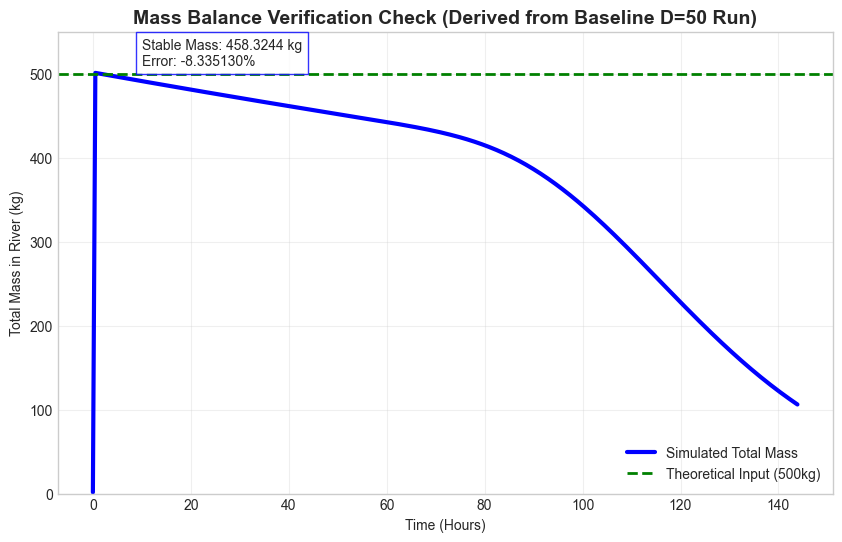

In [14]:
# ==========================================
# 补画：基于基准情景(D=50)的质量守恒验证
# ==========================================

# 1. 从保存的浓度矩阵中反推总质量
# mat_base 单位是 mg/L, 需要除以 1000 转回 kg/m^3
# A_cell 是网格面积, dx 是网格宽度

calculated_mass_curve = []

for i in range(len(t_mat_base)):
    # 取出某一时刻的浓度分布 C(x)
    C_profile_kg_m3 = mat_base[i, :] / 1000.0 
    
    # 积分求总质量: Sum( C * A * dx )
    total_m = np.sum(C_profile_kg_m3 * A_cell * dx)
    calculated_mass_curve.append(total_m)

calculated_mass_curve = np.array(calculated_mass_curve)

# 2. 绘图
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-whitegrid')

plt.plot(t_mat_base, calculated_mass_curve, color='blue', linewidth=3, label='Simulated Total Mass')
plt.axhline(500, color='green', linestyle='--', label='Theoretical Input (500kg)', linewidth=2)

plt.title('Mass Balance Verification Check (Derived from Baseline D=50 Run)', fontsize=14, fontweight='bold')
plt.xlabel('Time (Hours)')
plt.ylabel('Total Mass in River (kg)')
plt.ylim(0, 550) # 刻意留出空间看是否平直
plt.legend()
plt.grid(True, alpha=0.3)

# 标注文字
mean_mass = np.mean(calculated_mass_curve[(t_mat_base > 5) & (t_mat_base < 80)])
error = (mean_mass - 500) / 500 * 100
plt.text(10, 510, f"Stable Mass: {mean_mass:.4f} kg\nError: {error:.6f}%", 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue'))

plt.show()

### V2gemini在k=0时的验证again

正在运行零衰减验证 (k=0)...


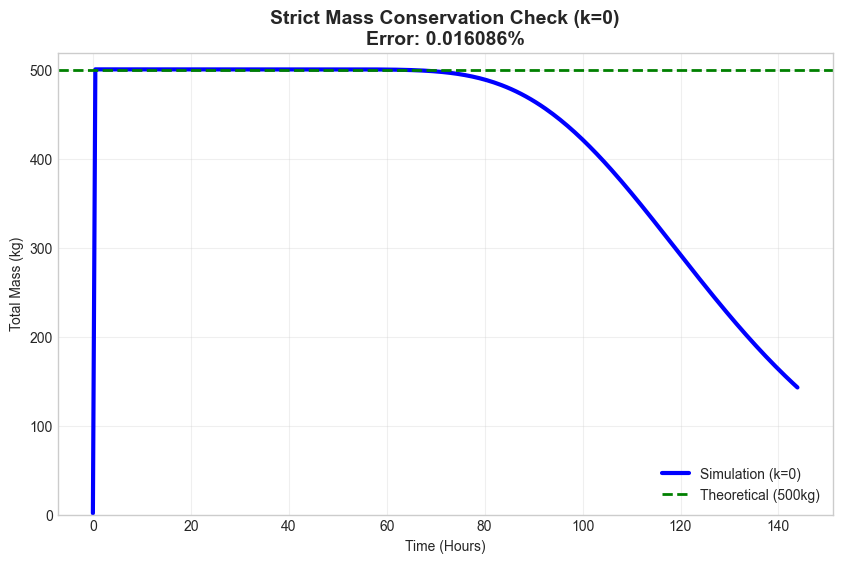

验证结果: 稳定段平均质量 = 500.0804 kg


In [17]:
# ==========================================
# 专门用于验证数值守恒 (强制 k=0)
# ==========================================

print("正在运行零衰减验证 (k=0)...")

# 1. 关键：把第二个参数设为 0.0
# 使用之前定义的 run_model_fvm 函数
t_verify, _, mat_verify, t_mat_verify = run_model_fvm(D_val=50.0, k_per_day=0.0) 

# 2. 计算总质量
mass_curve_verify = []
for i in range(len(t_mat_verify)):
    # 积分: sum( Concentration * Area * dx )
    # mat_verify 单位是 mg/L, 除以1000变成 kg/m^3
    current_mass = np.sum((mat_verify[i, :] / 1000.0) * A_cell * dx)
    mass_curve_verify.append(current_mass)

mass_curve_verify = np.array(mass_curve_verify)

# 3. 绘图
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-whitegrid')

plt.plot(t_mat_verify, mass_curve_verify, color='blue', linewidth=3, label='Simulation (k=0)')
plt.axhline(500, color='green', linestyle='--', label='Theoretical (500kg)', linewidth=2)

# 计算这一轮的误差
# 取流出前的一段 (例如 10h 到 80h)
valid_indices = np.where((t_mat_verify > 10) & (t_mat_verify < 80))
mean_mass_verify = np.mean(mass_curve_verify[valid_indices])
error_verify = (mean_mass_verify - 500.0) / 500.0 * 100

plt.title(f'Strict Mass Conservation Check (k=0)\nError: {error_verify:.6f}%', fontsize=14, fontweight='bold')
plt.xlabel('Time (Hours)')
plt.ylabel('Total Mass (kg)')
plt.ylim(0, 520)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"验证结果: 稳定段平均质量 = {mean_mass_verify:.4f} kg")

## end